In [1]:
%config IPCompleter.greedy=True

In [2]:
import pandas as pd
import numpy as np

# sklearn
from imblearn.over_sampling import SMOTE
# modeli
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# ostalo
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, normalize
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Sklearn Evaluation Metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

# scipy
from scipy import ndimage #za gaussijanski filter
from scipy.signal import savgol_filter
from scipy.stats import zscore
from scipy.fft import rfft, rfftfreq

#crtanje
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_theme()
sns.set(style="white")

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin

class FastFourierTransform(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        pass
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        transformed = np.abs(rfft(X, axis=1))
        return transformed
    
class SavGolTransform(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        pass
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        transformed = savgol_filter(X,21,4,deriv=0)
        return transformed

class NormalizeTransform(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        pass
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        transformed = normalize(X)
        return transformed

In [4]:
print("Loading data...")
train_data = pd.read_csv("exoTrain.csv")#.fillna(0)
test_data = pd.read_csv("exoTest.csv")#.fillna(0)
print("Data loaded.")

Loading data...
Data loaded.


In [4]:
train_data.isna().sum().any()

False

Odlično! Nema nedefiniranih podataka. Pogledajmo sada tablicu izbliza.

In [5]:
train_data

LABEL   FLUX.1   FLUX.2   FLUX.3   FLUX.4   FLUX.5   FLUX.6  FLUX.7  \
0         2    93.85    83.81    20.10   -26.98   -39.56  -124.71 -135.18   
1         2   -38.88   -33.83   -58.54   -40.09   -79.31   -72.81  -86.55   
2         2   532.64   535.92   513.73   496.92   456.45   466.00  464.50   
3         2   326.52   347.39   302.35   298.13   317.74   312.70  322.33   
4         2 -1107.21 -1112.59 -1118.95 -1095.10 -1057.55 -1034.48 -998.34   
...     ...      ...      ...      ...      ...      ...      ...     ...   
5082      1   -91.91   -92.97   -78.76   -97.33   -68.00   -68.24  -75.48   
5083      1   989.75   891.01   908.53   851.83   755.11   615.78  595.77   
5084      1   273.39   278.00   261.73   236.99   280.73   264.90  252.92   
5085      1     3.82     2.09    -3.29    -2.88     1.66    -0.75    3.85   
5086      1   323.28   306.36   293.16   287.67   249.89   218.30  188.86   

       FLUX.8  FLUX.9  ...  FLUX.3188  FLUX.3189  FLUX.3190  FLUX.3191  \
0      -96.27  -79.89  ...     -78.07    -102.15    -102.15      25.13   
1      -85.33  -83.97  ...      -3.28     -32.21     -32.21     -24.89   
2      486.39  436.56  ...     -71.69      13.31      13.31     -29.89   
3      311.31  312.42  ...       5.71      -3.73      -3.73      30.05   
4    -1022.71 -989.57  ...    -594.37    -401.66    -401.66    -357.24   
...       ...     ...  ...        ...        ...        ...        ...   
5082   -49.25  -30.92  ...     139.95     147.26     156.95     155.64   
5083   458.87  492.84  ...     -26.50      -4.84     -76.30     -37.84   
5084   254.88  237.60  ...     -26.82     -53.89     -48.71      30.99   
5085    -0.03    3.28  ...      10.86      -3.23      -5.10      -4.61   
5086   178.93  118.93  ...      71.19       0.97      55.20      -1.63   

      FLUX.3192  FLUX.3193  FLUX.3194  FLUX.3195  FLUX.3196  FLUX.3197  
0         48.57      92.54      39.32      61.42       5.08     -39.54  
1         -4.86       0.76     -11.70       6.46      16.00      19.93  
2        -20.88       5.06     -11.80     -28.91     -70.02     -96.67  
3         20.03     -12.67      -8.77     -17.31     -17.35      13.98  
4       -443.76    -438.54    -399.71    -384.65    -411.79    -510.54  
...         ...        ...        ...        ...        ...        ...  
5082     156.36     151.75     -24.45     -17.00       3.23      19.28  
5083    -153.83    -136.16      38.03     100.28     -45.64      35.58  
5084      15.96      -3.47      65.73      88.42      79.07      79.43  
5085      -9.82      -1.50      -4.65     -14.55      -6.41      -2.55  
5086      -5.50     -25.33     -41.31     -16.72     -14.09      27.82  

[5087 rows x 3198 columns]

In [6]:
train_data["LABEL"].value_counts()

1    5050
2      37
Name: LABEL, dtype: int64

LABEL je target data i govori o tome je li zvjezda u retku ima egzoplanet ili nema, a svaki FLUX je intenzitet svjetlosti razmaknut u jednakim intervalima.

Bilo bi zgodno promijeniti oznake 1->0 i 2->1 pa će tako 0 značiti da zvijezda nema planet, a 1 da ima planet.

Ima svega 37 zvijezdi koje imaju egzoplanet u podacima za treniranje kao što se vidi u prethodnoj ćeliji, a 5050 onih koji nemaju. Ovaj dataset je jako nebalansiran. To će vjerojatno stvarati probleme kod klasifikacije pa ćemo možda razmisliti o rebalansiranju pomoću oversamplanja manjine (SMOTE funkcija). U ovom slučaju manjina su zvijezde koje *imaju* egzoplanet

In [7]:
# # mijenjanje oznaka
# train_data["LABEL"] = train_data["LABEL"].apply(lambda x: 0 if x==1 else 1)
# test_data["LABEL"] = test_data["LABEL"].apply(lambda x: 0 if x==1 else 1)

In [5]:
# Učitaj nanovo podatke bez ikakvih transformacija
def reset_data(df_train, df_test):
    train = df_train.copy()
    test = df_test.copy()
    
    #pretvori LABEL u tvrdnje istinitosti 0 i 1
    train["LABEL"] = train["LABEL"].apply(lambda x: 0 if x==1 else 1)
    test["LABEL"] = test["LABEL"].apply(lambda x: 0 if x==1 else 1)
    
    #razdvoji feature i labele
    X_train = train.drop(["LABEL"], axis = 1)
    y_train = train["LABEL"].ravel()
    X_test = test.drop(["LABEL"], axis = 1)
    y_test = test["LABEL"].ravel()
    
    #makni retke koji sadrže outliere u train data
    zscores = zscore(X_train)
    abszscores = np.abs(zscores)
    filtered_indices = (abszscores<3).all(axis=1)
    X_train = X_train[filtered_indices]
    y_train = y_train[filtered_indices]
    
    return X_train, X_test, y_train, y_test

In [6]:
X_train, X_test, y_train, y_test = reset_data(train_data, test_data)

In [10]:
# #X_train[(np.abs(zscore(X_train))<3)]
# zscores = zscore(X_train)
# abszscores = np.abs(zscores)
# filtered_indices = (abszscores<3).all(axis=1)
# X_train = X_train[filtered_indices]
# y_train = y_train[filtered_indices]

Probajmo sada vizualizirati podatke i vidjeti s čime imamo posla. Nacrtati ćemo svih 37 slika koje pripadaju zvijezdama s egzoplanetima, a zatim nekoliko koje nemaju egzoplanete.

Nakon što sam maknuo retke s outlierima otišao je i jedan redak s egzoplanetom tako da ih sada ima 36.

In [6]:
def draw_exo(data, n):
    if isinstance(data,np.ndarray):        
        fig = plt.figure(figsize=(24,40))
        for i in range(n):
            ax = fig.add_subplot(14,4,i+1)
            ax.scatter(np.arange(len(data[0])),data[i][:],s=0.5)
    else:
        fig = plt.figure(figsize=(24,40))
        for i in range(n):
            ax = fig.add_subplot(14,4,i+1)
            ax.scatter(np.arange(3197),data.iloc[i,:],s=0.5)

def draw_noexo(data, n):
    if isinstance(data,np.ndarray):
        fig = plt.figure(figsize=(24,40))
        for i in range(n):
            ax = fig.add_subplot(14,4,i+1)
            ax.scatter(np.arange(len(data[0])),data[i+37][:],s=0.5)
    else:
        fig = plt.figure(figsize=(24,40))
        for i in range(n):
            ax = fig.add_subplot(14,4,i+1)
            ax.scatter(np.arange(3197),data.iloc[i+37,:],s=0.5)

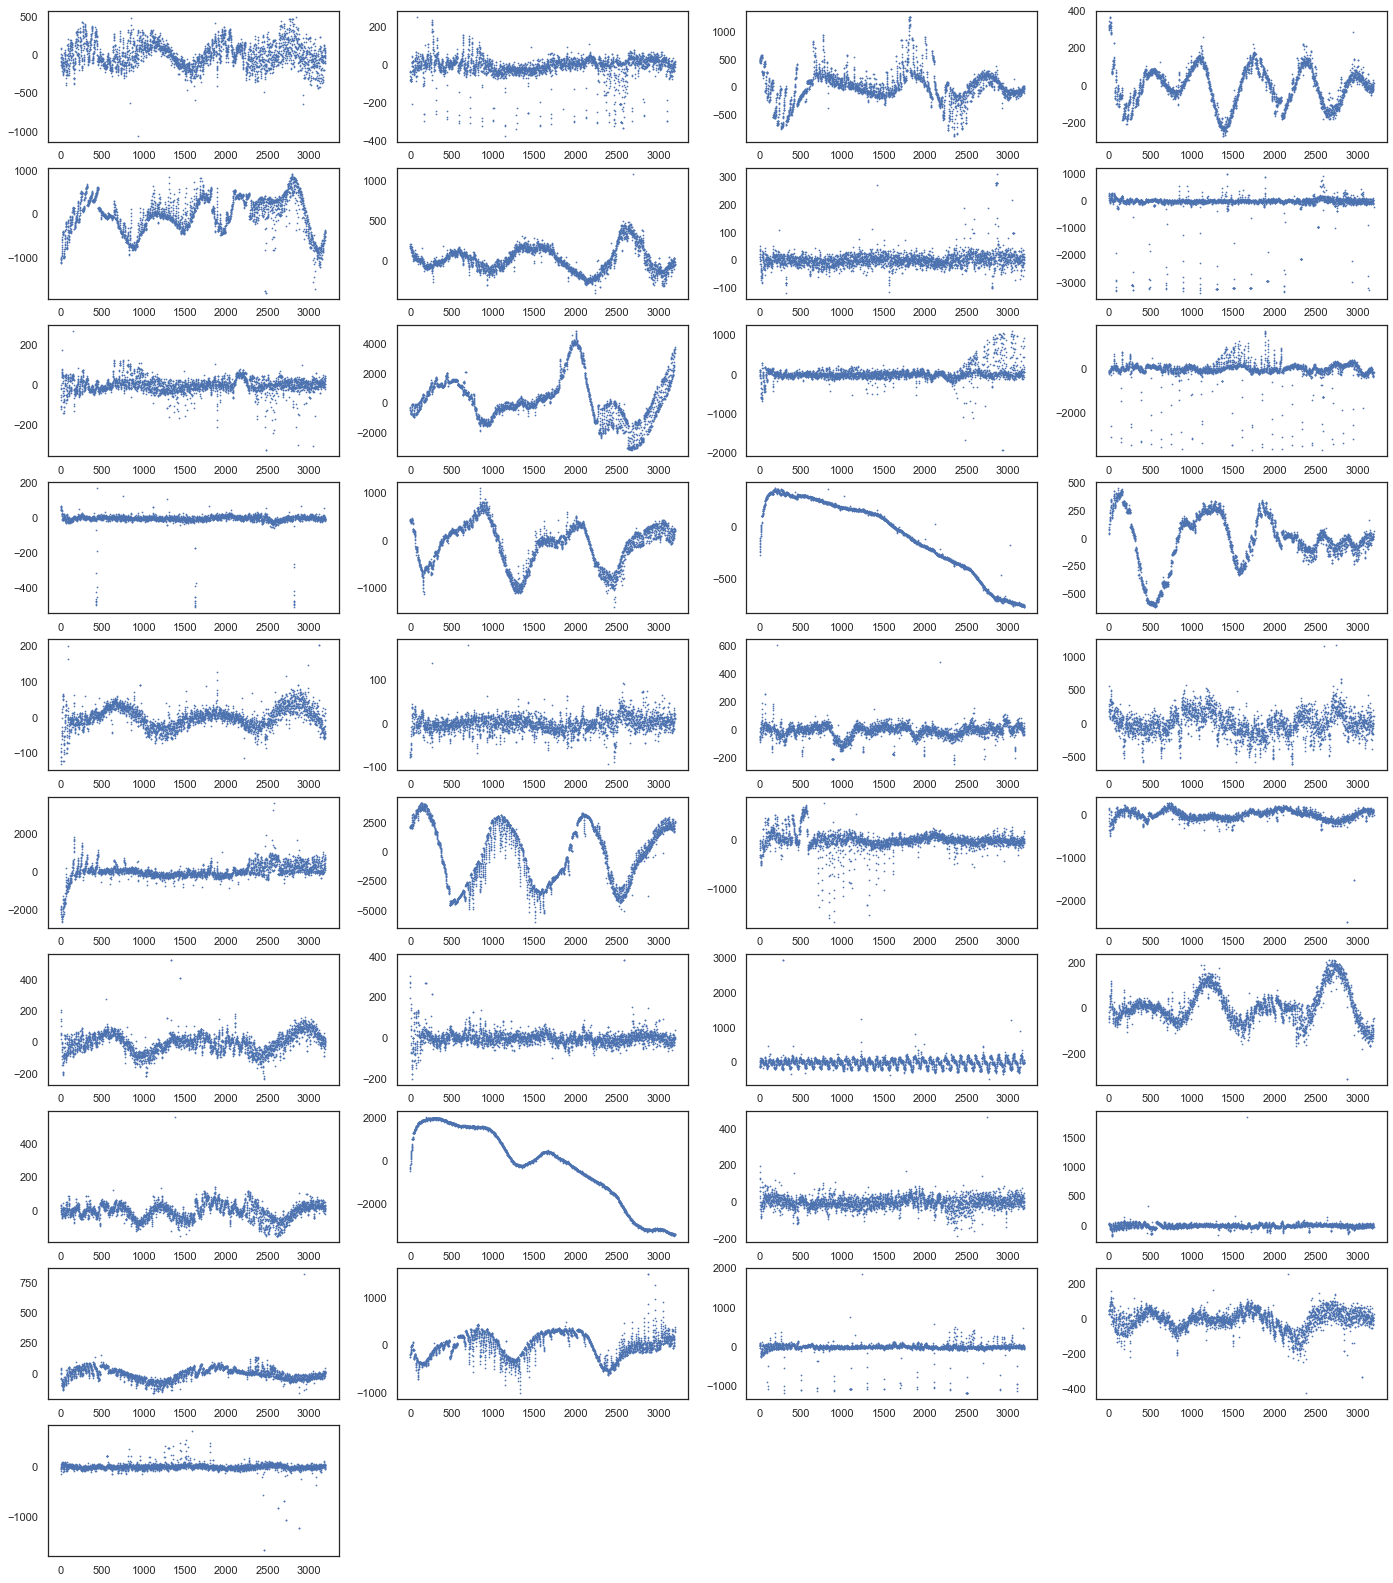

In [12]:
draw_exo(X_train, 37)

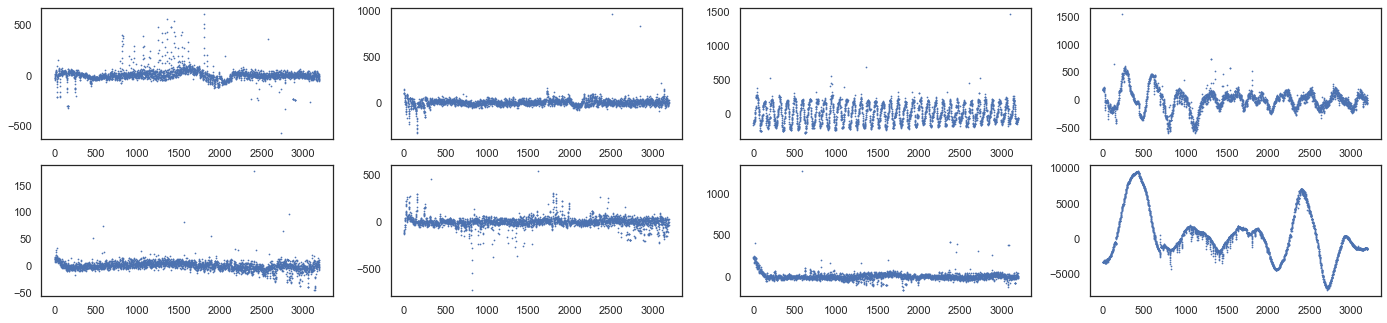

In [13]:
draw_noexo(X_train, 8)

Može se primijetiti da svjetlost zvijezdi bez planeta uglavnom izgledaju periodično dok se kod onih koje imaju egzoplanete pojavljuju udubljenja. Probajmo skalirati podatke na usporedivu skalu i vidjeti možemo li bolje učiti neke obrasce. Imajući na umu outliere također ćemo skalirati podatke sa Robust Scalerom.

S obzirom da je teško uvidjeti obrasce u ovim podacima imam sumnju da neće podaci davati dobre rezultate ovakvi kakvi jesu. Osim toga pretpostavljam da će podaci međusobno jako slabo korelirati zbog velike količine šuma u podacima. 

Zbog toga predlažem prebacivanje signala u frekventnu domenu, odnosno napraviti Fourierovu transformaciju nad retcima osim skaliranja. Na taj način transformacija bi trebala uhvatiti frekvencije koje predstavljaju prolaske egzoplaneta (udubine u grafovima) i na pripadnim mjestima bi se trebali vidjeti vrhovi u grafu.

Kasnije sam provjerio i korelacije nisu baš bile od pomoći. Obrisao sam te ćelije. PCA koji sam proveo nad podacima nakon transformacija davali su jako loše rezultate učenja, a vizualno se činilo kao da su uništili podatke u smislu da grafovi pojedinih redaka nisu bili baš raspoznatljivi.



In [9]:
norm = NormalizeTransform()
robust = RobustScaler()
fft = FastFourierTransform()
savgol = SavGolTransform()
std_scaler = StandardScaler()

X_train, X_test, y_train, y_test = reset_data(train_data, test_data)

x_train = X_train.copy()
x_train = fft.fit_transform(x_train)
x_train = savgol.fit_transform(x_train)
x_train = norm.fit_transform(x_train)
x_train = robust.fit_transform(x_train)
#x_train = std_scaler.fit_transform(x_train)

# x_test = X_test.copy()
# x_test = fft.fit_transform(x_test)
# x_test = savgol.fit_transform(x_test)
# x_test = norm.fit_transform(x_test)
# x_test = robust.fit_transform(x_test)
#x_test = std_scaler.fit_transform(x_test)
#x_train = ndimage.filters.gaussian_filter(x_train, sigma = 1)

Tu se malo igram s kombinacijama transformacija i crtam ispod. Odlučio sam izgladiti funkcije sa Savitzky–Golay filterom kako bih izrazio vrhove. Taj filter izglađuje šum, a očuva oblike i visine peakova (https://ieeexplore.ieee.org/document/5888646). Grafovima su se najbolje istaknuli vrhovi za poredak transformacija u ćeliji iznad. Odnosno pokazuju svoje karakteristike najbolje na ovaj način. Može se primijetiti kako zvijezde s planetima uglavnom imaju izražene uske vrhove u frekventnoj domeni. Uglavnom u sredini karakteristike ili blizu početka i kraja. Zvijezde bez planeta pojavljuju se na 2 načina; imaju vrhove na početku i kraju što znači da je signal miran i bez puno oscilacija, ili su jako šumoviti bez izraženih vrhova koji se mogu prstom izdvojiti.

Kad se Fourier primijeni nakon svih ostalih transformacija rezultati nisu baš dobri. Bolje učenje se vidi kada je Fourier prva transformacija.

Kasnije se pokazalo da za ovaj poredak algoritmi zaista bolje rade. Slično vrijedi i za StandardScaler iako su grafovi malo dramatičniji. No evo prvo nekoliko slika. Prvih 36 su zvijezde s planetima i zatim 8 bez.

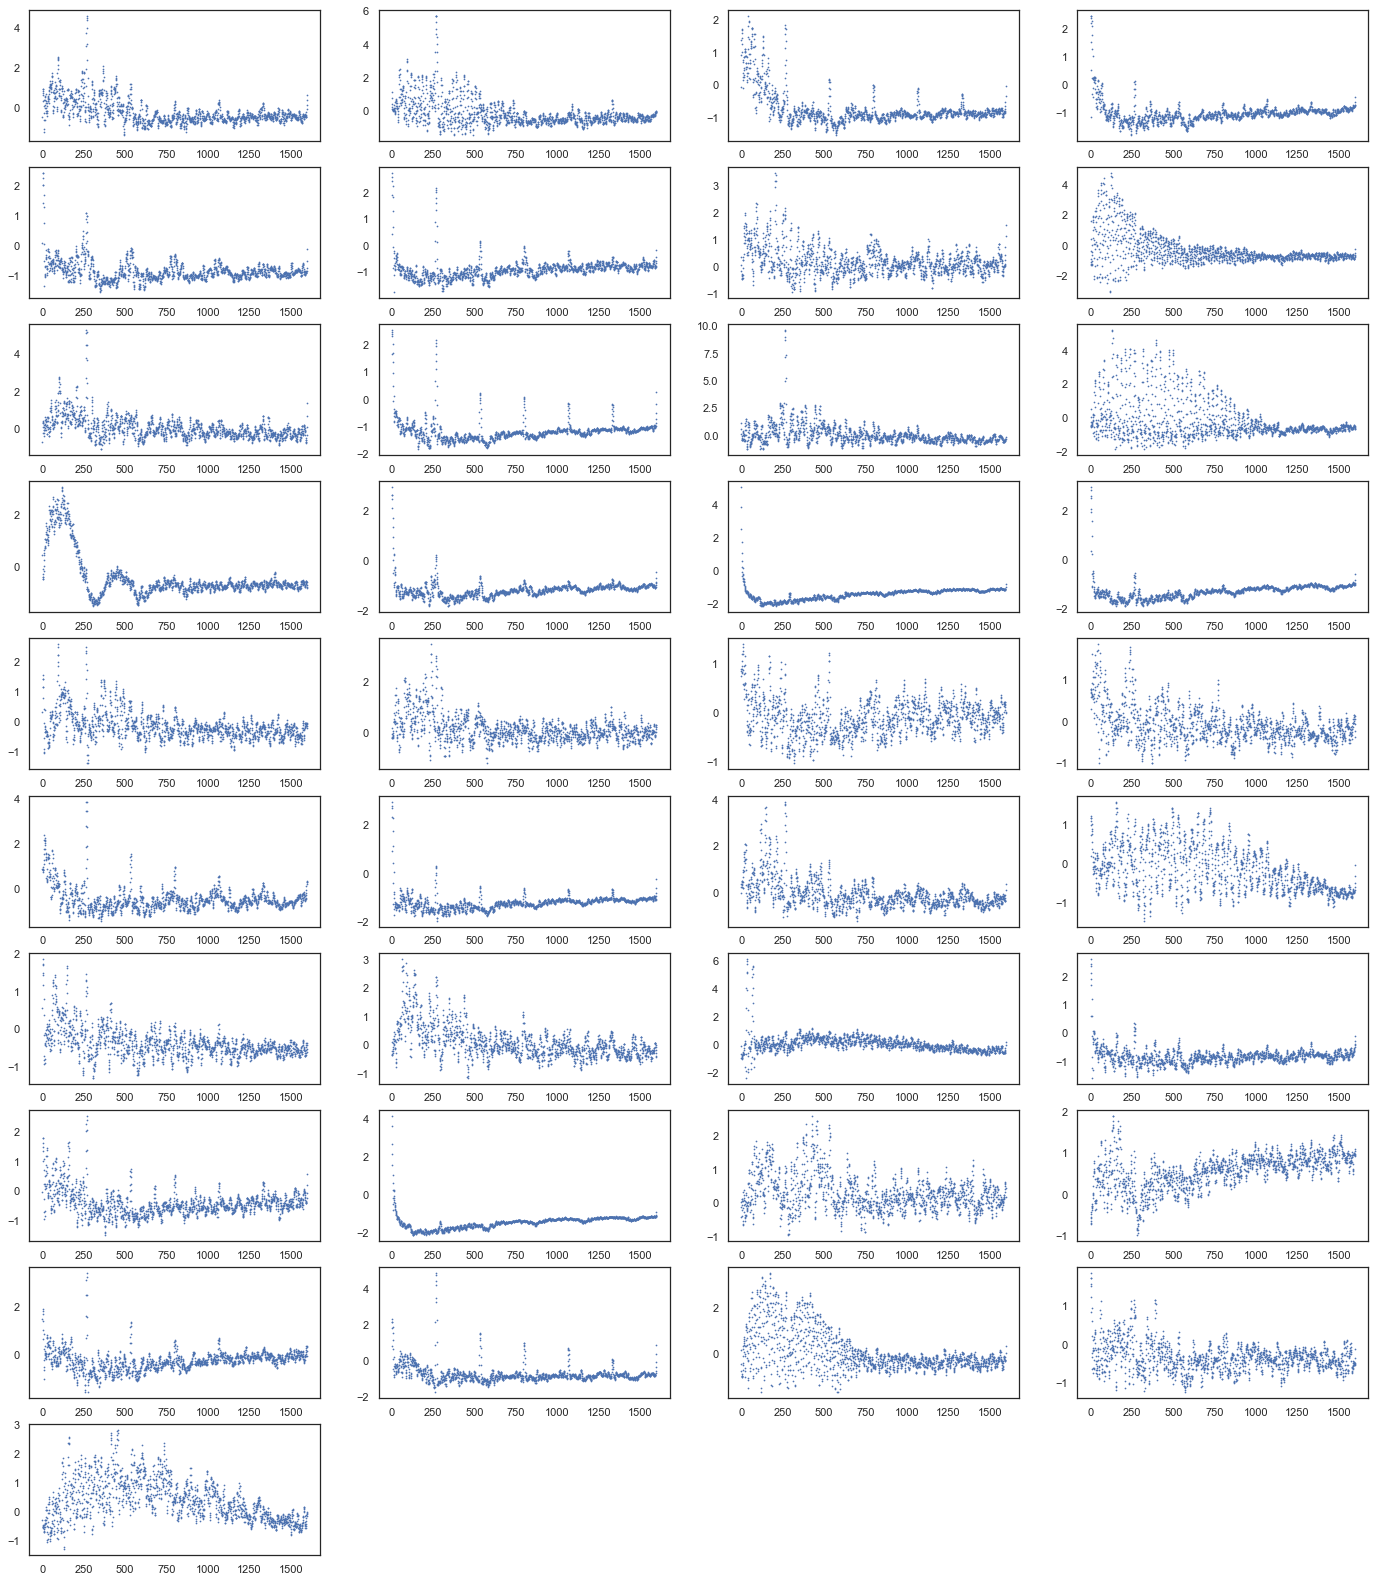

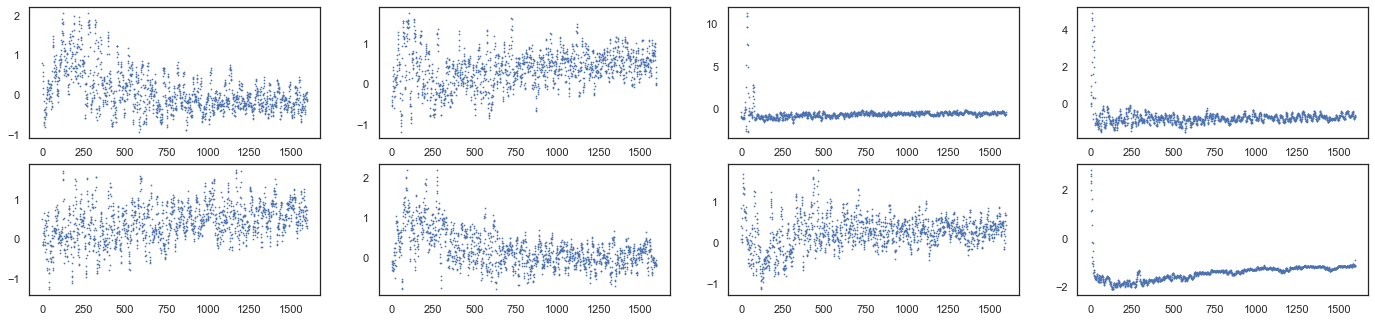

In [15]:
draw_exo(x_train, 37)
draw_noexo(x_train, 8)

In [41]:
data_prep_1 = Pipeline([("savgol", SavGolTransform()),
                      ("normalizer", NormalizeTransform()),
                      ("robust_scaler", RobustScaler()),
                      ("fft", FastFourierTransform())])

data_prep_2 = Pipeline([("fft", FastFourierTransform()),
                      ("savgol", SavGolTransform()),
                      ("normalizer", NormalizeTransform()),
                      ("robust_scaler", RobustScaler()),])

data_prep_3 = Pipeline([("savgol", SavGolTransform()),
                      ("normalizer", NormalizeTransform()),
                      ("robust_scaler", RobustScaler()),])

data_prep_4 = Pipeline([("fft", FastFourierTransform()),
                      ("savgol", SavGolTransform()),
                      ("normalizer", NormalizeTransform()),
                      ("std_scaler", StandardScaler()),])

data_prep_5 = Pipeline([("fft", FastFourierTransform()),
                      ("savgol", SavGolTransform()),
                      ("normalizer", NormalizeTransform())
                       ])

Ovdje se može vidjeti nekoliko poredaka transformacija koje ću uspoređivati na modelima. Crta se prvih 8 zvijezda koje sadrže planet

In [17]:
transformed = data_prep_1.fit_transform(X_train)

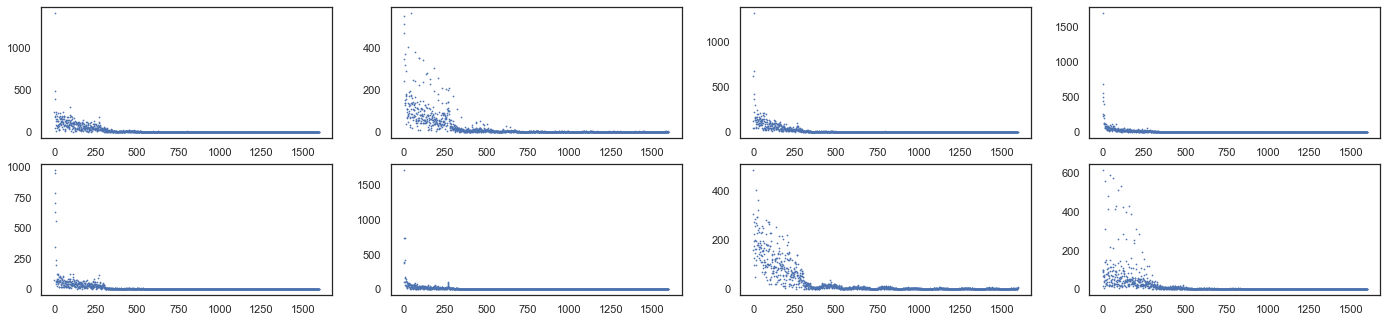

In [18]:
draw_exo(transformed, 8)

In [19]:
transformed_fft_first = data_prep_2.fit_transform(X_train)

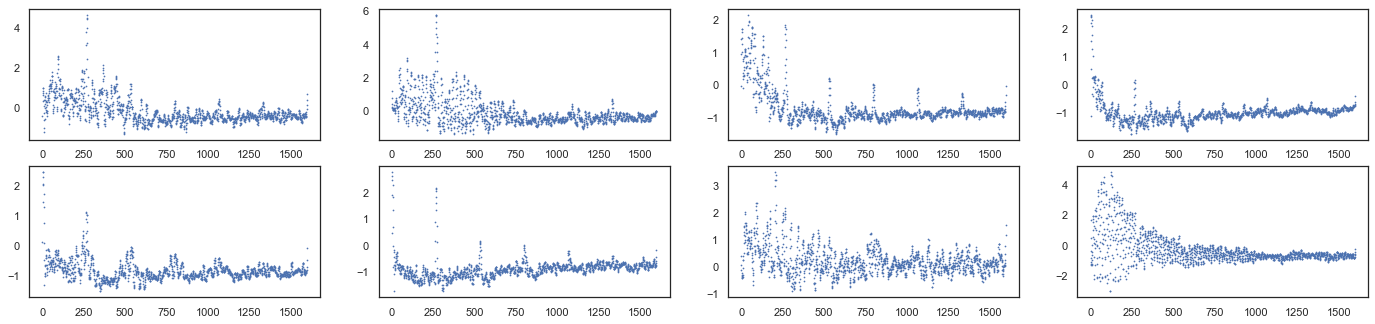

In [20]:
draw_exo(transformed_fft_first, 8)

In [21]:
transformed_no_fft = data_prep_3.fit_transform(X_train)

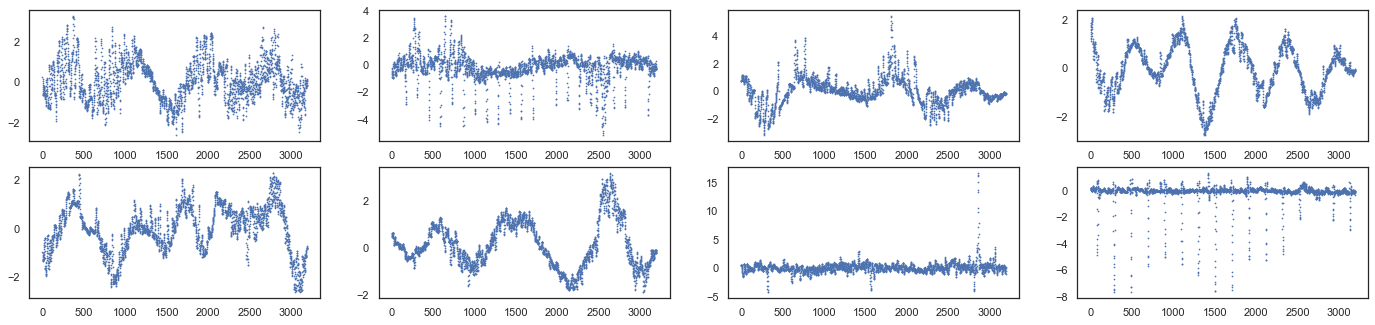

In [22]:
draw_exo(transformed_no_fft, 8)

In [23]:
transformed_std = data_prep_4.fit_transform(X_train)

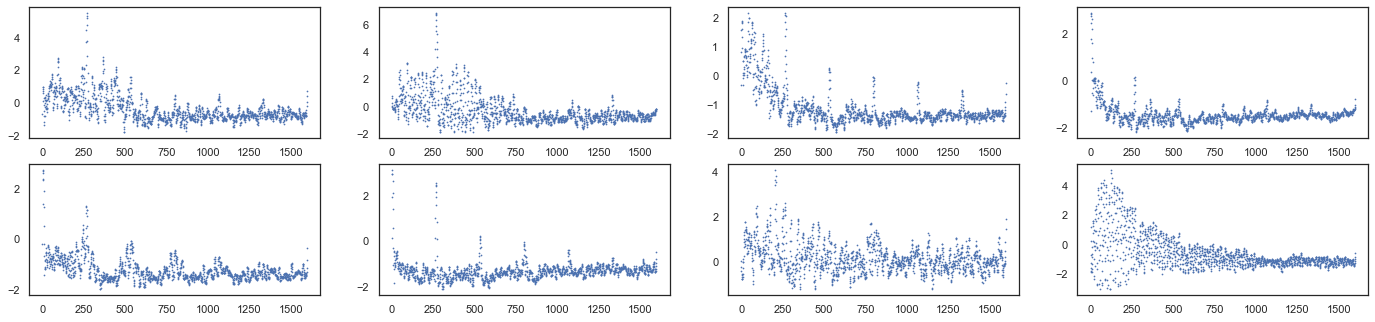

In [24]:
draw_exo(transformed_std, 8)

In [32]:
X_train, X_test, y_train, y_test = reset_data(train_data, test_data)
transformed_5 = data_prep_5.fit_transform(X_train)

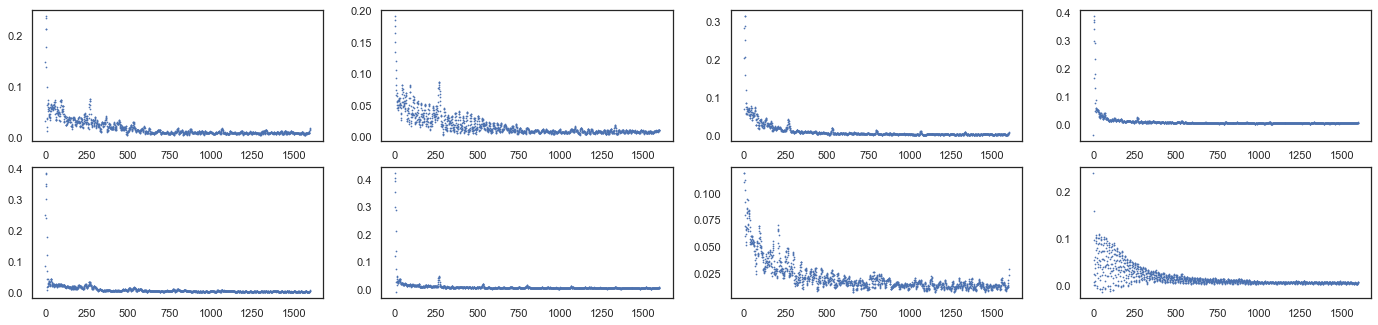

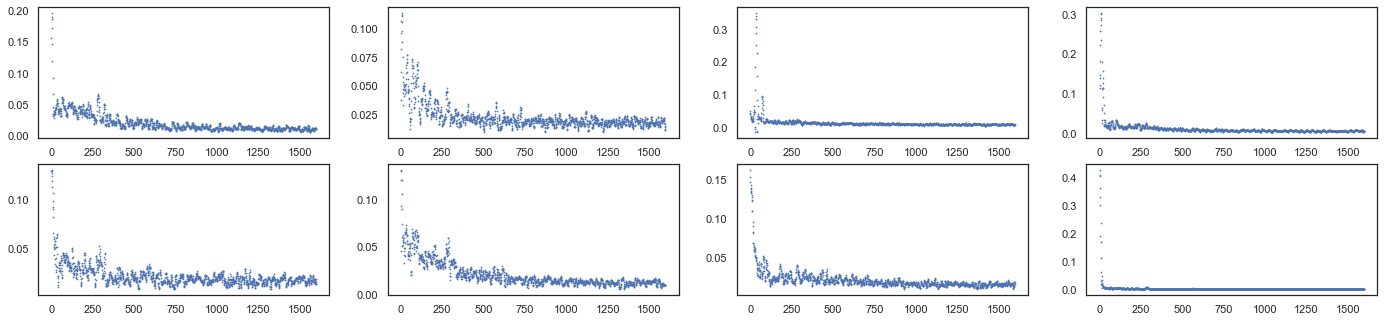

In [33]:
draw_exo(transformed_5, 8)
draw_noexo(transformed_5, 8)

In [16]:
#funkcija za testiranje modela
def test_model(estimator, X_train_, X_test_, y_train_, y_test_):
    estimator.fit(X_train_, y_train_)
    prediction=estimator.predict(X_test_)
    print()
    print(type(estimator).__name__)
    print()
    #ispis svih vrijednosti
    print(classification_report(y_test,prediction))
    #crtanje
    fig = plt.figure(figsize=(22,7), num=type(estimator).__name__)
    ax = fig.add_subplot(1,3,1)
    sns.heatmap(confusion_matrix(y_test_,prediction),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
    ax = fig.add_subplot(1,3,2)
    metrics.plot_roc_curve(estimator, X_test_, y_test_, ax=ax)
    plt.plot([0, 1], [0, 1], 'k--')
    ax = fig.add_subplot(1,3,3)
    metrics.plot_precision_recall_curve(estimator, X_test_, y_test_, ax=ax)
    f1=metrics.f1_score(y_test_, prediction)
    print("F1:", f1)

In [77]:
svc = SVC()
logreg = LogisticRegression(max_iter=500, n_jobs=-1)
knn = KNeighborsClassifier(n_jobs=-1)
tree = DecisionTreeClassifier()
forest = RandomForestClassifier(n_jobs=1)
models = [svc, logreg, knn, tree, forest]
#test_model(DecisionTreeClassifier(), X_train, X_test, y_train, y_test)


SVC

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



C:\Users\Tamed Wicked\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1: 0.0

LogisticRegression

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       0.67      0.40      0.50         5

    accuracy                           0.99       570
   macro avg       0.83      0.70      0.75       570
weighted avg       0.99      0.99      0.99       570

F1: 0.5

KNeighborsClassifier

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



C:\Users\Tamed Wicked\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1: 0.0

DecisionTreeClassifier

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       565
           1       0.40      0.40      0.40         5

    accuracy                           0.99       570
   macro avg       0.70      0.70      0.70       570
weighted avg       0.99      0.99      0.99       570

F1: 0.4000000000000001

RandomForestClassifier

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       565
           1       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570

F1: 0.0
Wall time: 2min 24s


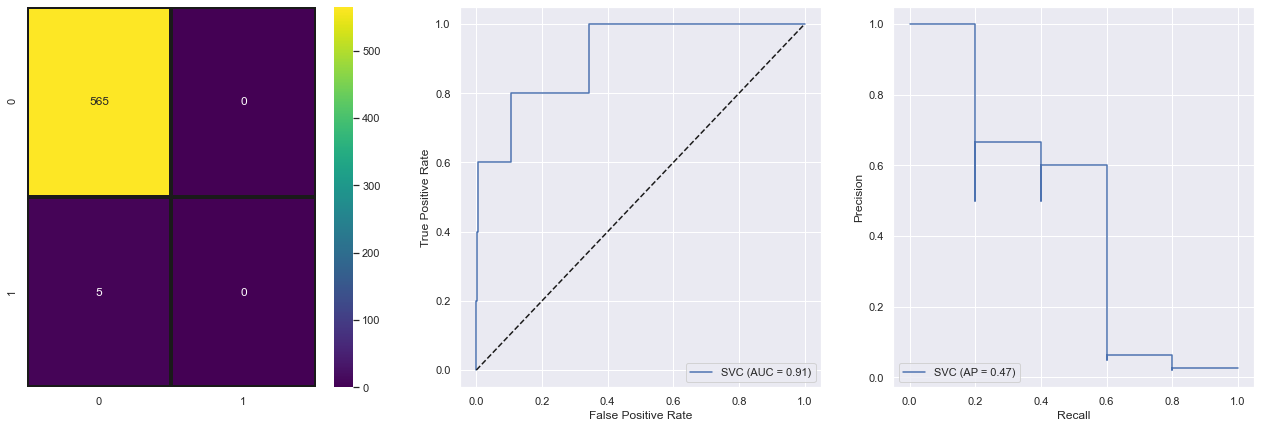

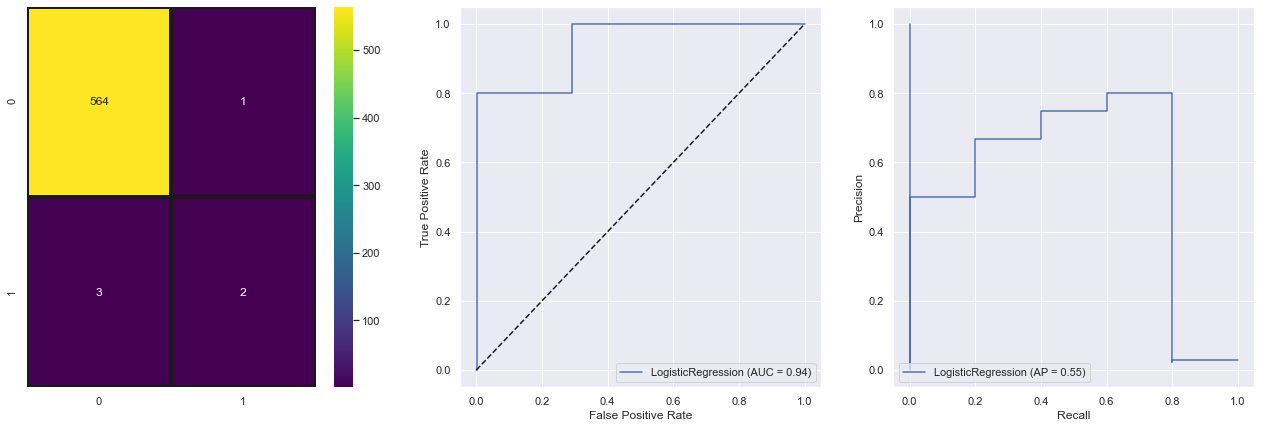

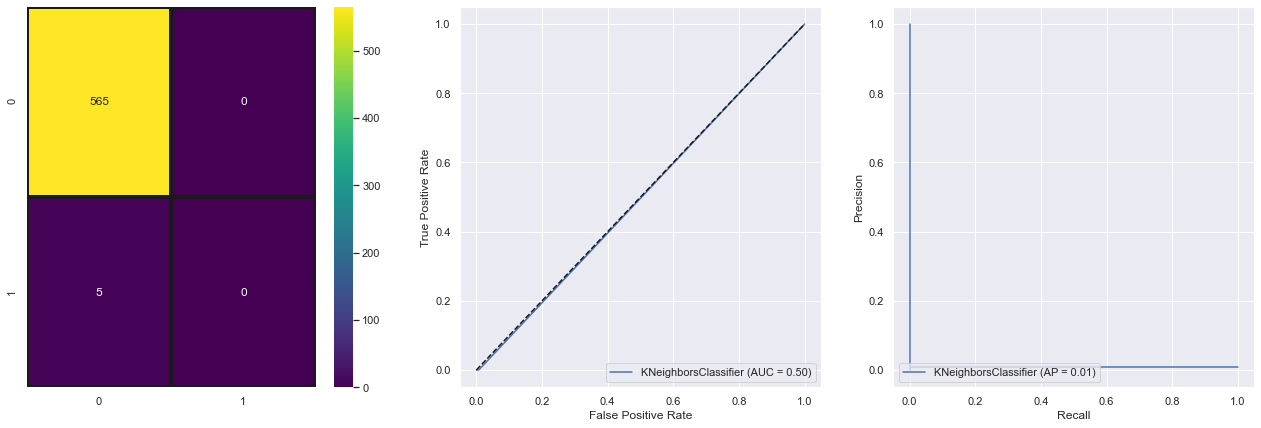

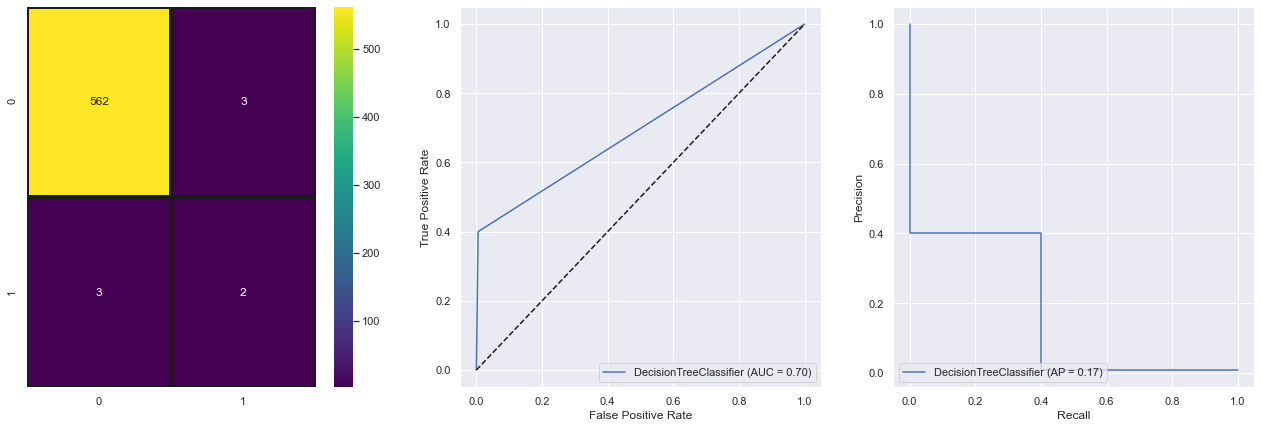

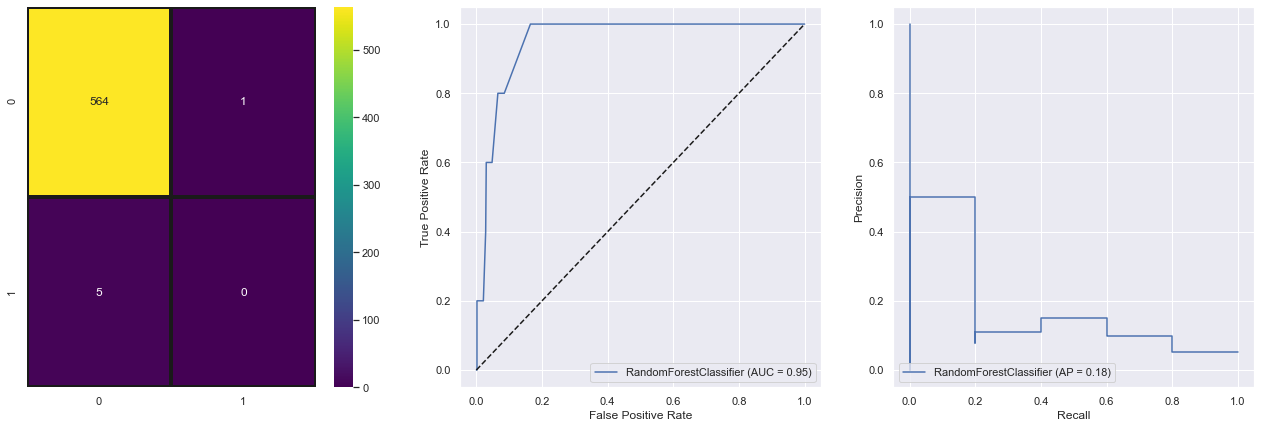

In [26]:
%%time
X_train, X_test, y_train, y_test = reset_data(train_data, test_data)
X_train = data_prep_1.fit_transform(X_train)
X_test = data_prep_1.fit_transform(X_test)
for m in models:
    test_model(m, X_train, X_test, y_train, y_test)


SVC

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       565
           1       1.00      0.60      0.75         5

    accuracy                           1.00       570
   macro avg       1.00      0.80      0.87       570
weighted avg       1.00      1.00      1.00       570

F1: 0.7499999999999999

LogisticRegression

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       565
           1       0.50      0.80      0.62         5

    accuracy                           0.99       570
   macro avg       0.75      0.90      0.81       570
weighted avg       0.99      0.99      0.99       570

F1: 0.6153846153846154

KNeighborsClassifier

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       565
           1       0.75      0.60      0.67         5

    accuracy                           0.99       570
   macro avg       0.87      0.8

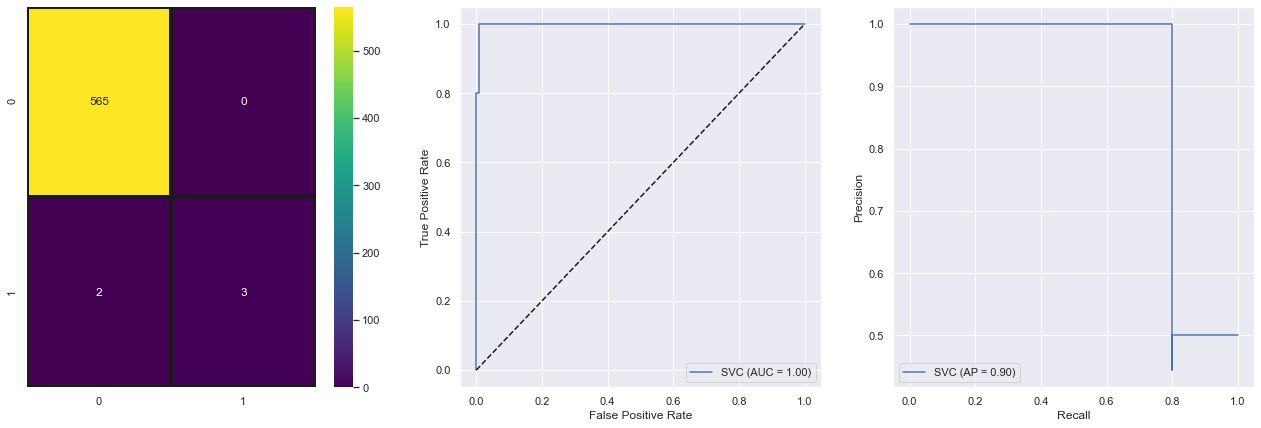

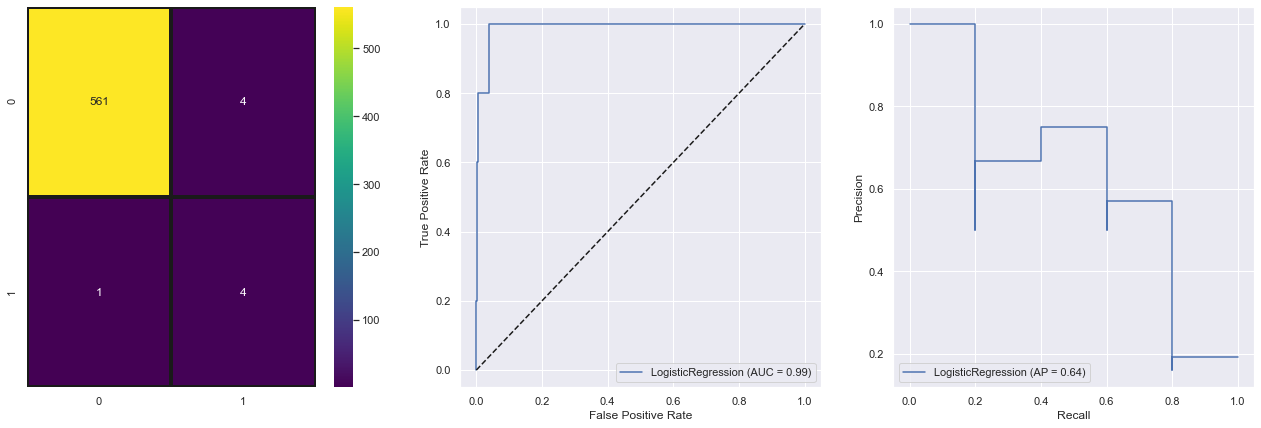

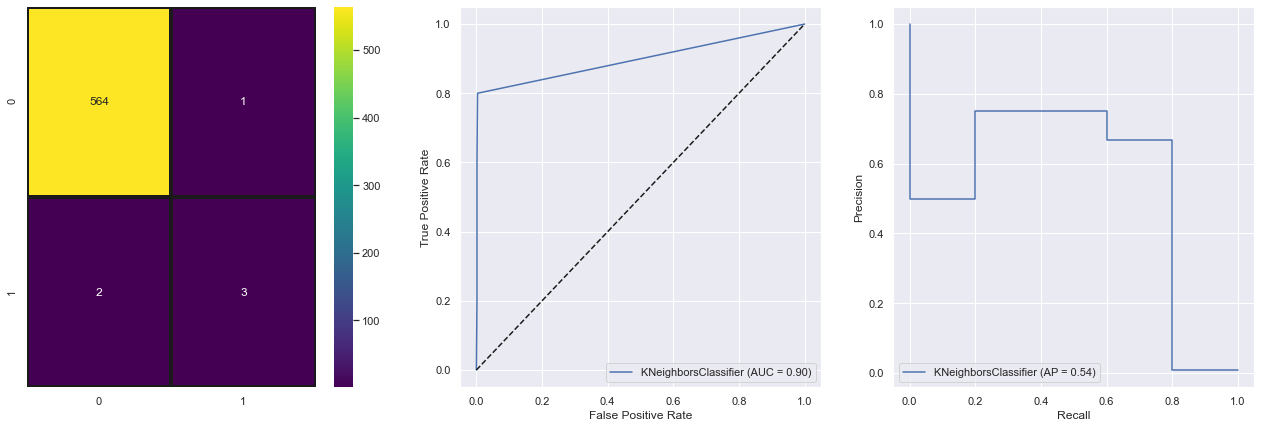

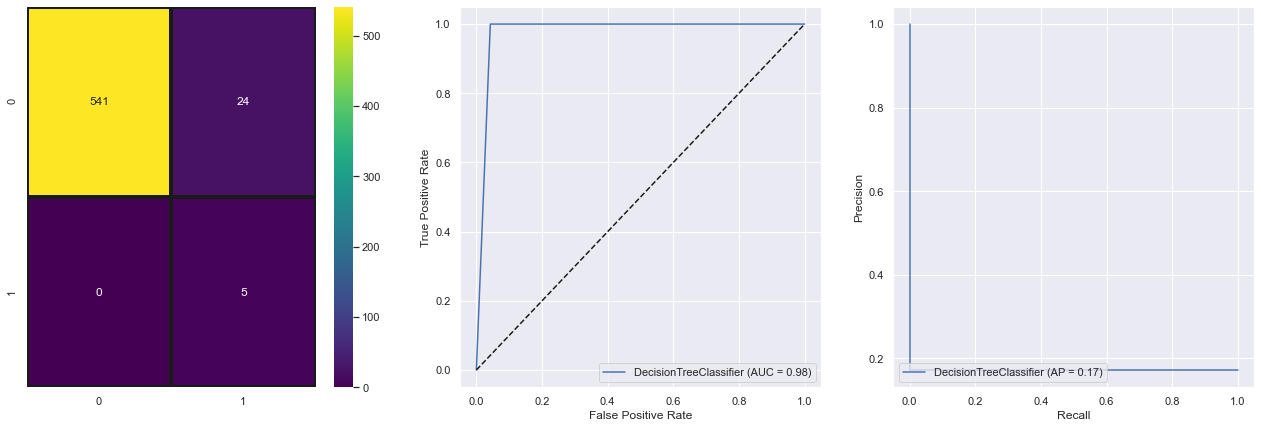

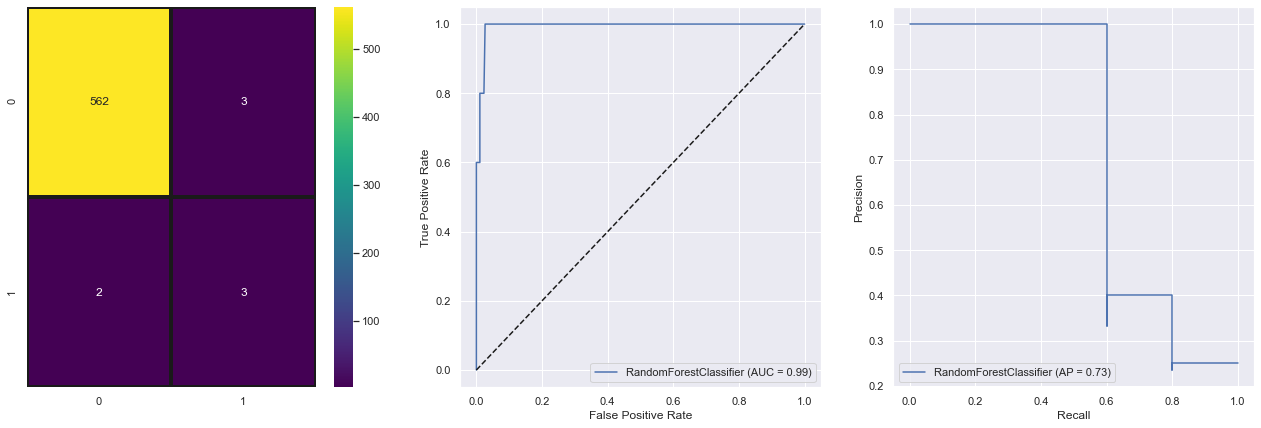

In [44]:
%%time
X_train, X_test, y_train, y_test = reset_data(train_data, test_data)
X_train = data_prep_2.fit_transform(X_train)
X_test = data_prep_2.fit_transform(X_test)
for m in models:
    test_model(m, X_train, X_test, y_train, y_test)


SVC

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



C:\Users\Tamed Wicked\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1: 0.0

LogisticRegression

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       565
           1       0.00      0.00      0.00         5

    accuracy                           0.97       570
   macro avg       0.50      0.49      0.49       570
weighted avg       0.98      0.97      0.98       570

F1: 0.0

KNeighborsClassifier

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



C:\Users\Tamed Wicked\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1: 0.0

DecisionTreeClassifier

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       565
           1       0.00      0.00      0.00         5

    accuracy                           0.97       570
   macro avg       0.50      0.49      0.49       570
weighted avg       0.98      0.97      0.98       570

F1: 0.0

RandomForestClassifier

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570

F1: 0.0
Wall time: 2min 25s


C:\Users\Tamed Wicked\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


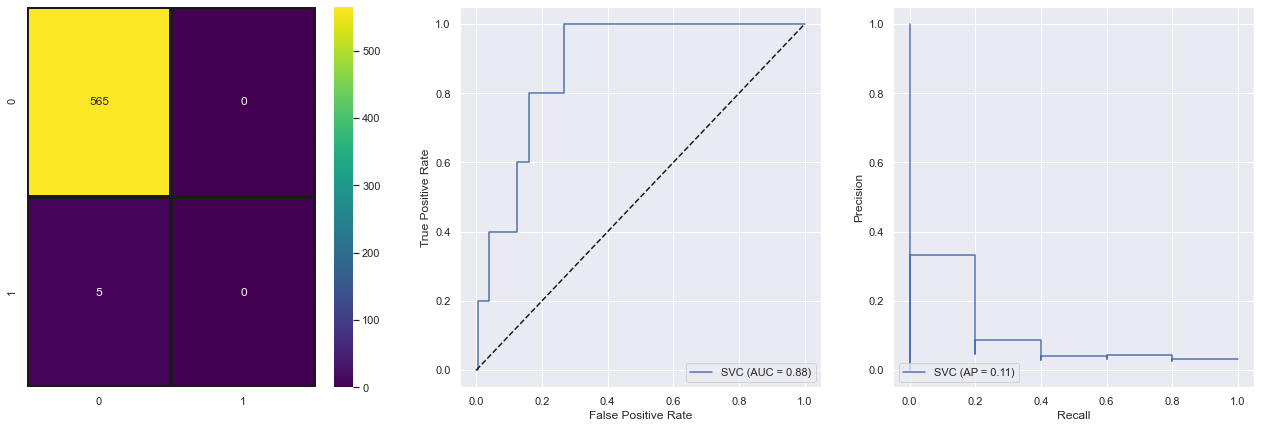

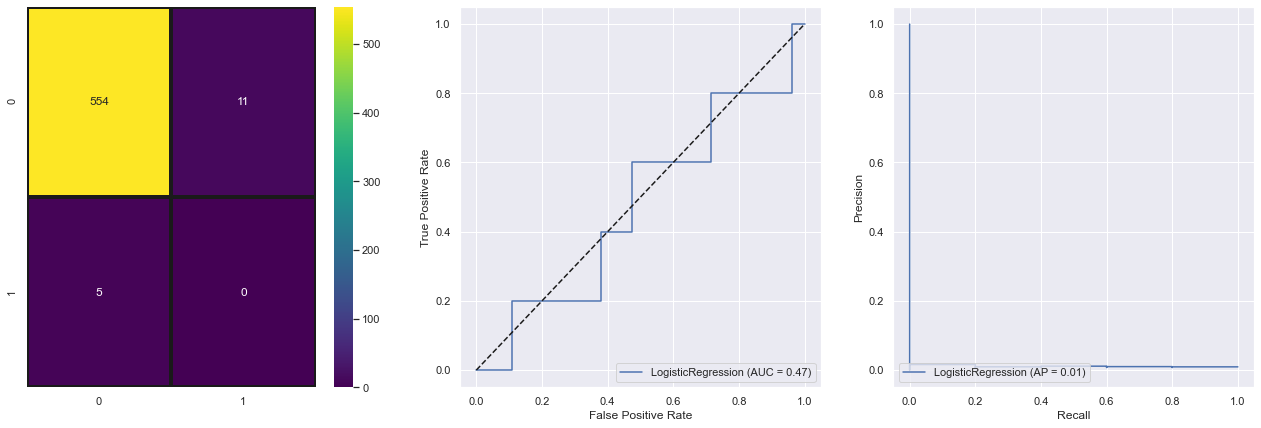

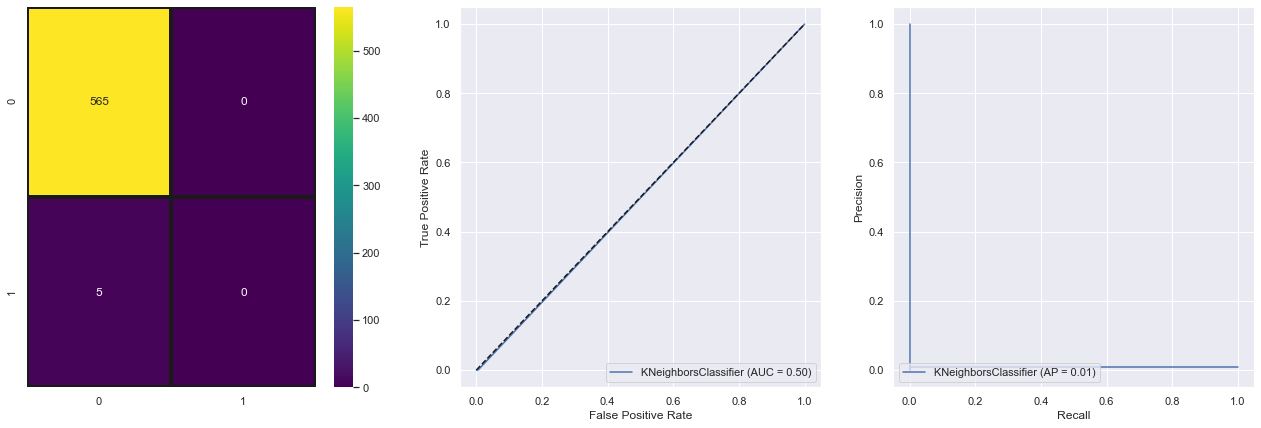

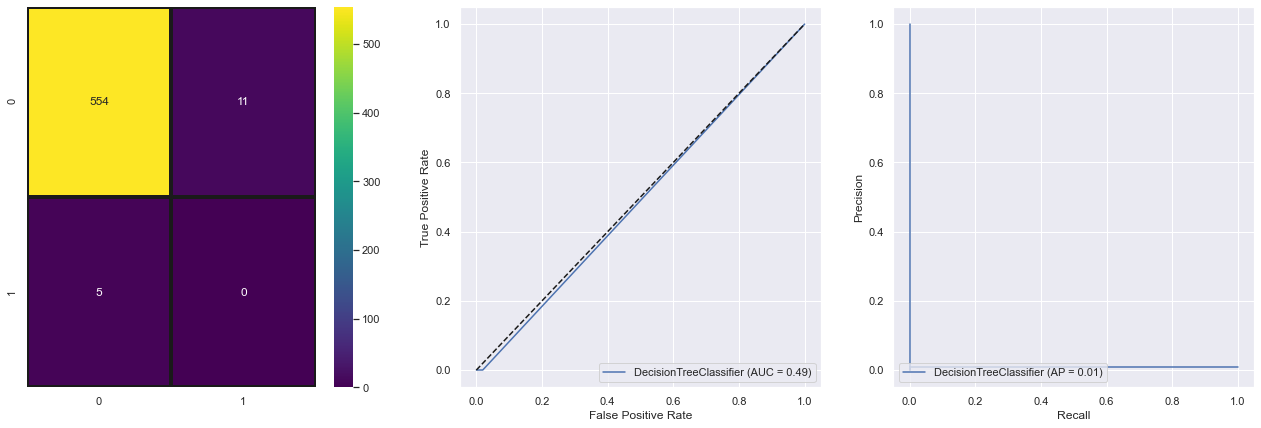

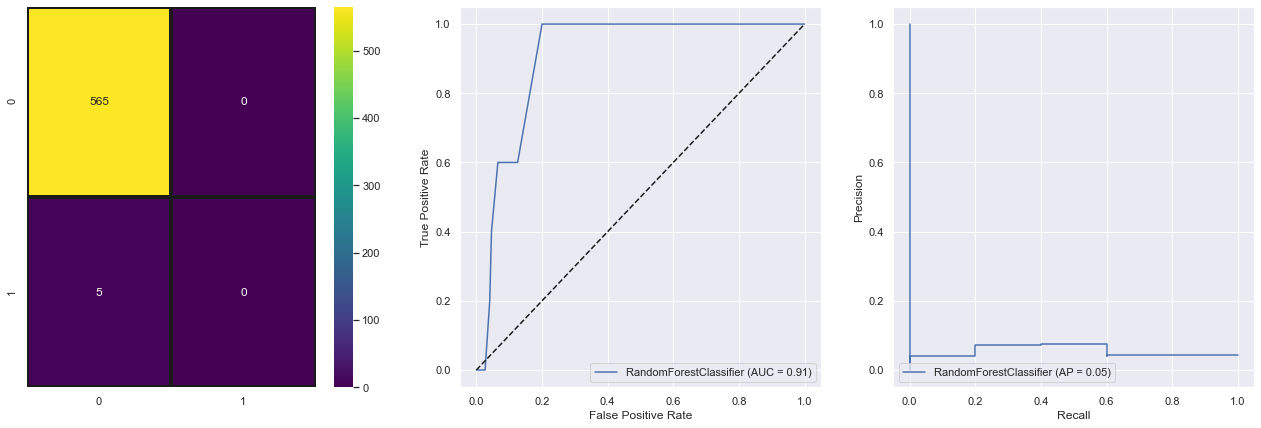

In [28]:
%%time
X_train, X_test, y_train, y_test = reset_data(train_data, test_data)
X_train = data_prep_3.fit_transform(X_train)
X_test = data_prep_3.fit_transform(X_test)
for m in models:
    test_model(m, X_train, X_test, y_train, y_test)


SVC

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       565
           1       1.00      0.60      0.75         5

    accuracy                           1.00       570
   macro avg       1.00      0.80      0.87       570
weighted avg       1.00      1.00      1.00       570

F1: 0.7499999999999999

LogisticRegression

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       565
           1       0.38      0.60      0.46         5

    accuracy                           0.99       570
   macro avg       0.69      0.80      0.73       570
weighted avg       0.99      0.99      0.99       570

F1: 0.4615384615384615

KNeighborsClassifier

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       0.50      0.20      0.29         5

    accuracy                           0.99       570
   macro avg       0.75      0.6

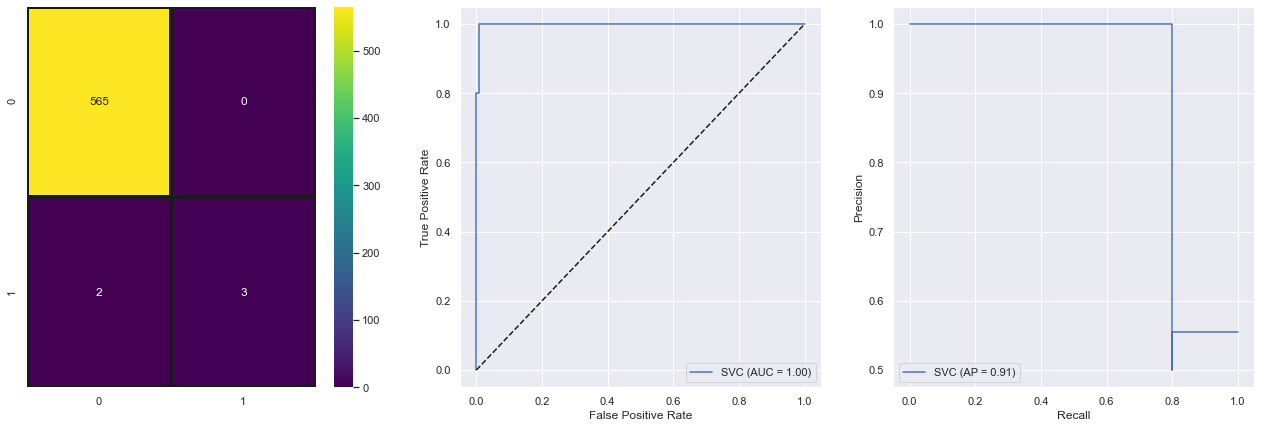

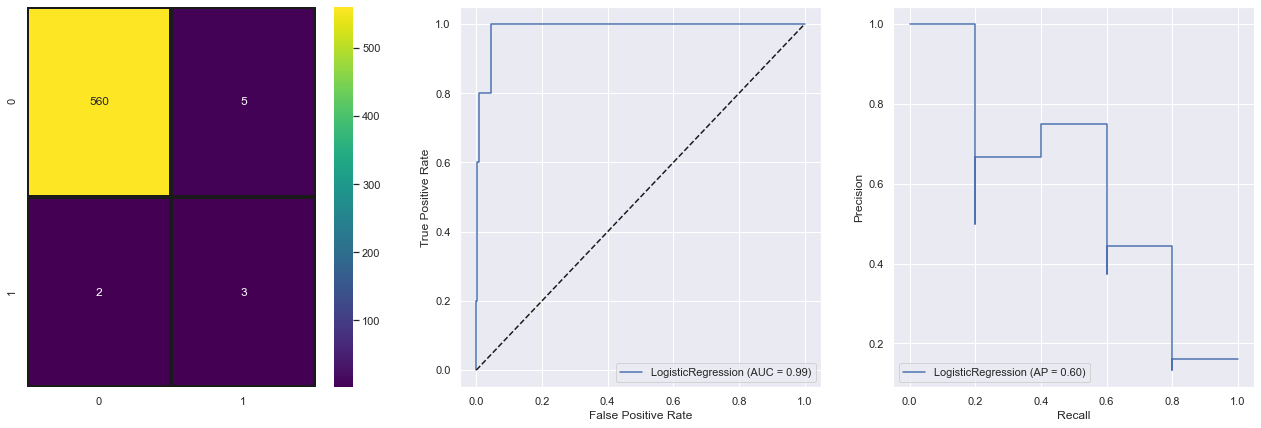

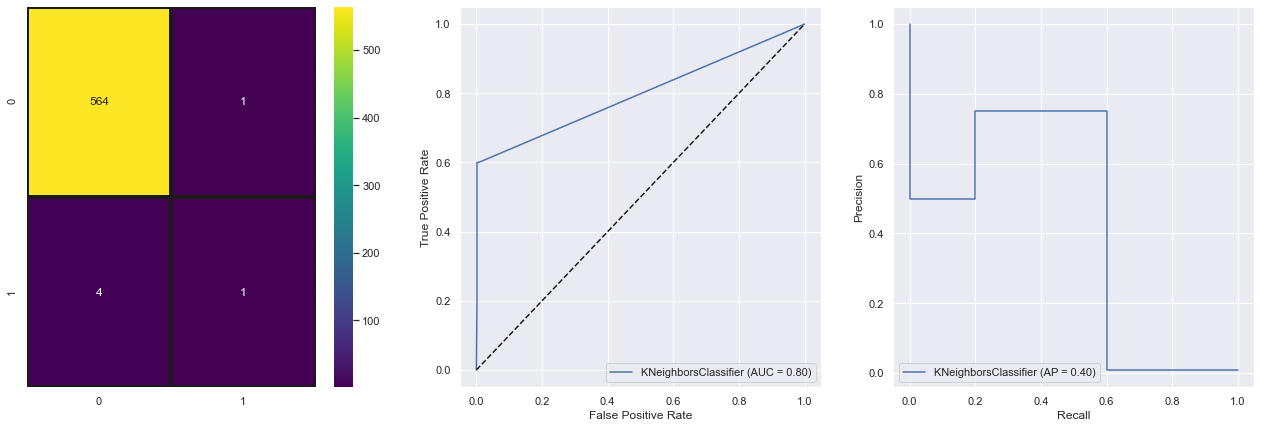

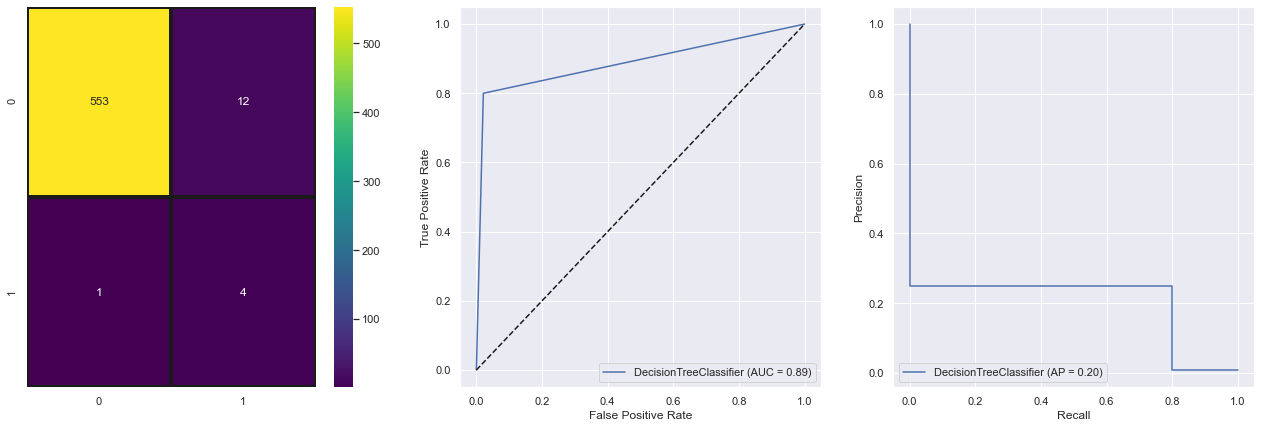

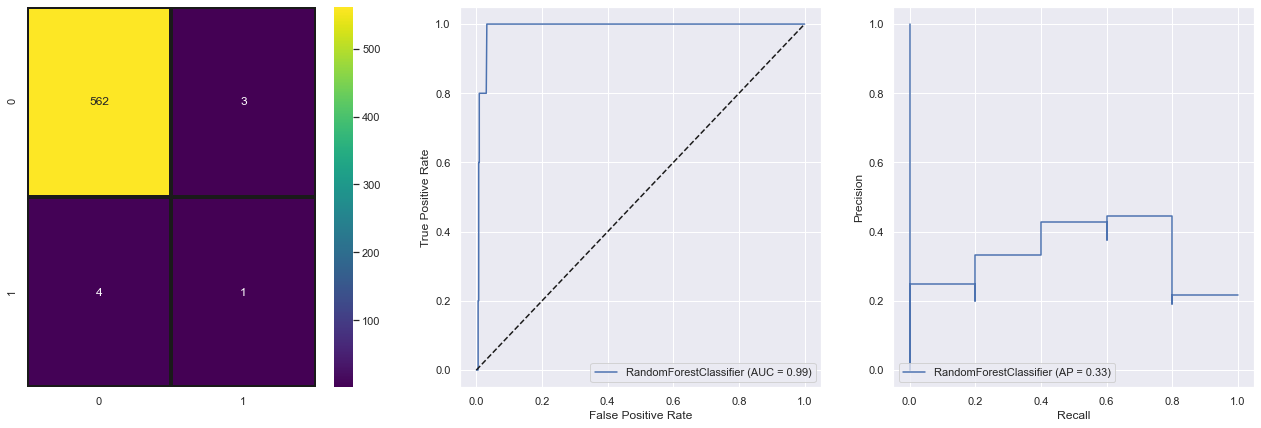

In [132]:
%%time
X_train, X_test, y_train, y_test = reset_data(train_data, test_data)
X_train = data_prep_4.fit_transform(X_train)
X_test = data_prep_4.fit_transform(X_test)
for m in models:
    test_model(m, X_train, X_test, y_train, y_test)

### Kao dobri kandidati čine se Logistic Regression, Decision Tree i Random Forest 

Kada prvo primijenimo fft pa tek onda ostale transformacije, recall (odnosno True positive rate! TP/(TP+FN)) je puno bolji. Bez obzira što su algoritmi predvidjeli nešto false positiva, zapravo su točno pronašli skoro sve zvijezde koje stvarno imaju planet.

k-NN bi također mogao biti dobar kandidat ako bi mu se mogao smanjiti broj false positiva.

No prije nego sasvim odlučimo pokušajmo prvo oversamplati manjinu (one zvijezde koje imaju planet) i vidjeti rezultate. Očito najbolje rezultate dobivamo za data_prep_2 i data_prep_4 pa ćemo za njih i provjeriti rezultate nakon oversamplanja

After OverSampling, counts of label '1': 4974
After OverSampling, counts of label '0': 4974

SVC

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       565
           1       0.50      0.60      0.55         5

    accuracy                           0.99       570
   macro avg       0.75      0.80      0.77       570
weighted avg       0.99      0.99      0.99       570

F1: 0.5454545454545454

LogisticRegression

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       565
           1       0.36      0.80      0.50         5

    accuracy                           0.99       570
   macro avg       0.68      0.89      0.75       570
weighted avg       0.99      0.99      0.99       570

F1: 0.5000000000000001

KNeighborsClassifier

              precision    recall  f1-score   support

           0       1.00      0.88      0.94       565
           1       0.06      0.80      0.11      

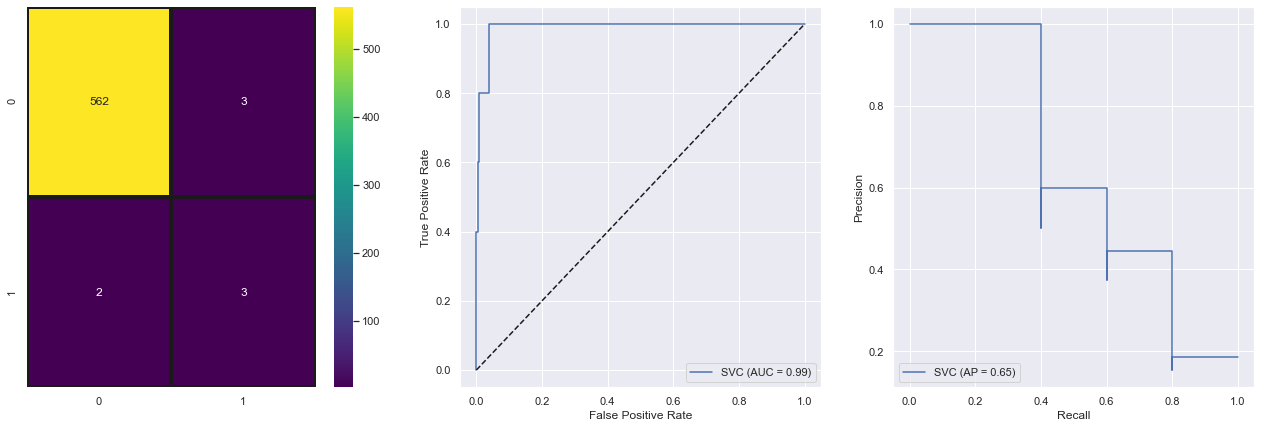

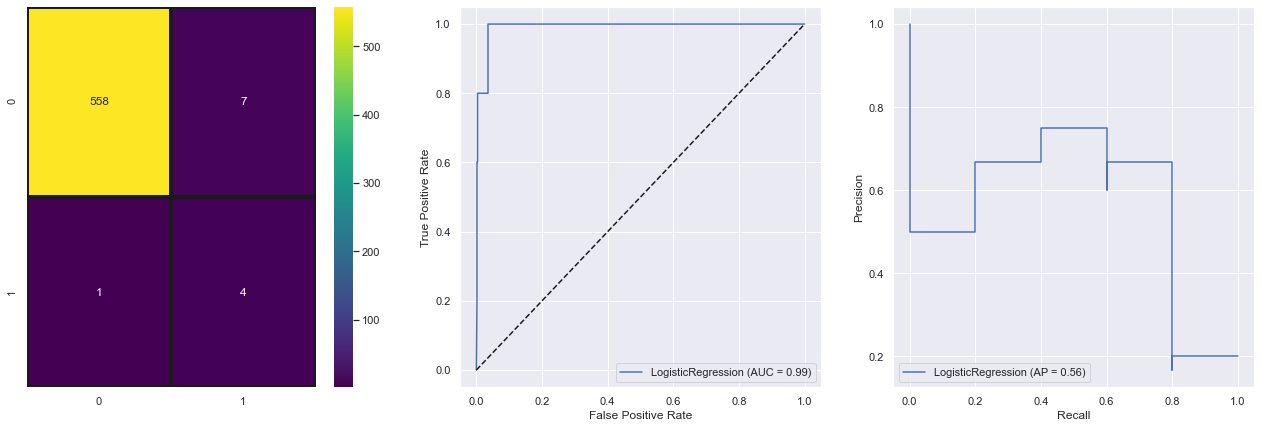

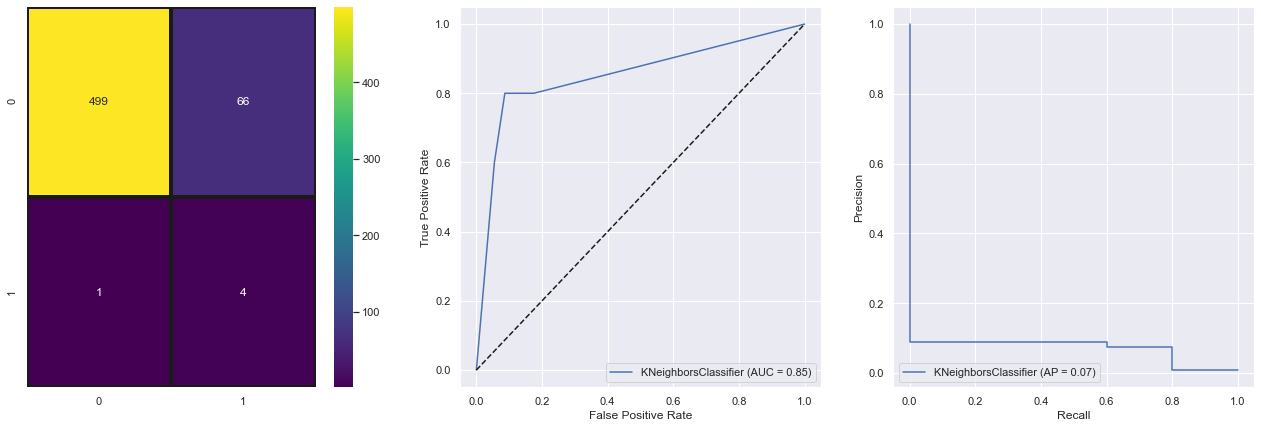

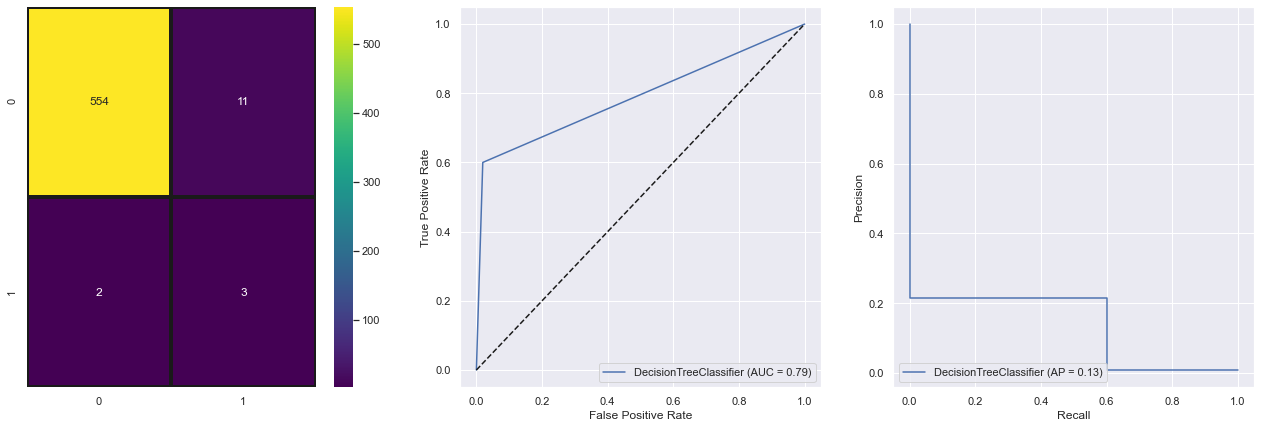

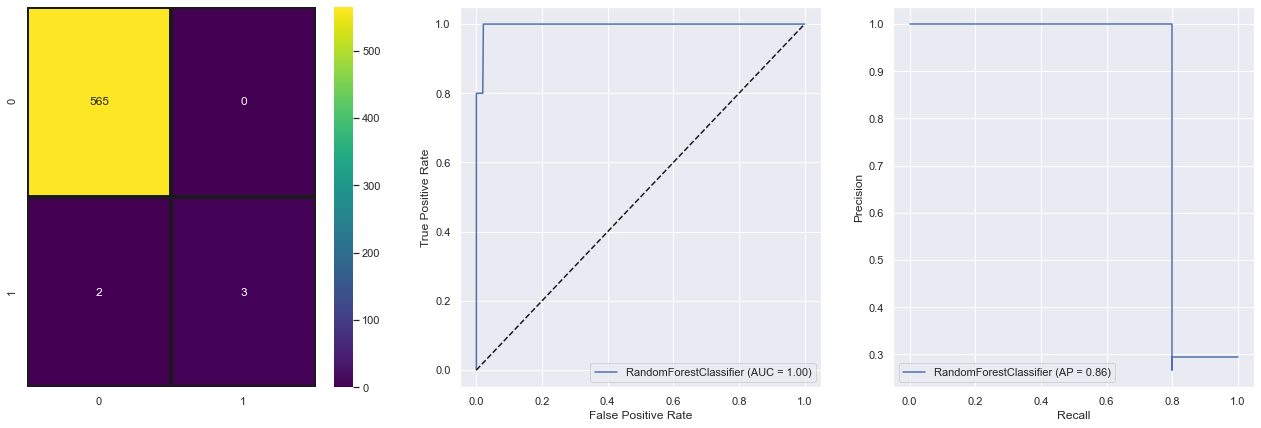

In [45]:
%%time
X_train, X_test, y_train, y_test = reset_data(train_data, test_data)
X_train = data_prep_2.fit_transform(X_train)
X_test = data_prep_2.fit_transform(X_test)

sm = SMOTE(random_state=42, n_jobs=-1)
X_train, y_train = sm.fit_resample(X_train, y_train)
print("After OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train==0)))

for m in models:
    test_model(m, X_train, X_test, y_train, y_test)

After OverSampling, counts of label '1': 4974
After OverSampling, counts of label '0': 4974

SVC

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       565
           1       0.50      0.60      0.55         5

    accuracy                           0.99       570
   macro avg       0.75      0.80      0.77       570
weighted avg       0.99      0.99      0.99       570

F1: 0.5454545454545454

LogisticRegression

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       565
           1       0.36      0.80      0.50         5

    accuracy                           0.99       570
   macro avg       0.68      0.89      0.75       570
weighted avg       0.99      0.99      0.99       570

F1: 0.5000000000000001

KNeighborsClassifier

              precision    recall  f1-score   support

           0       1.00      0.86      0.92       565
           1       0.05      0.80      0.09      

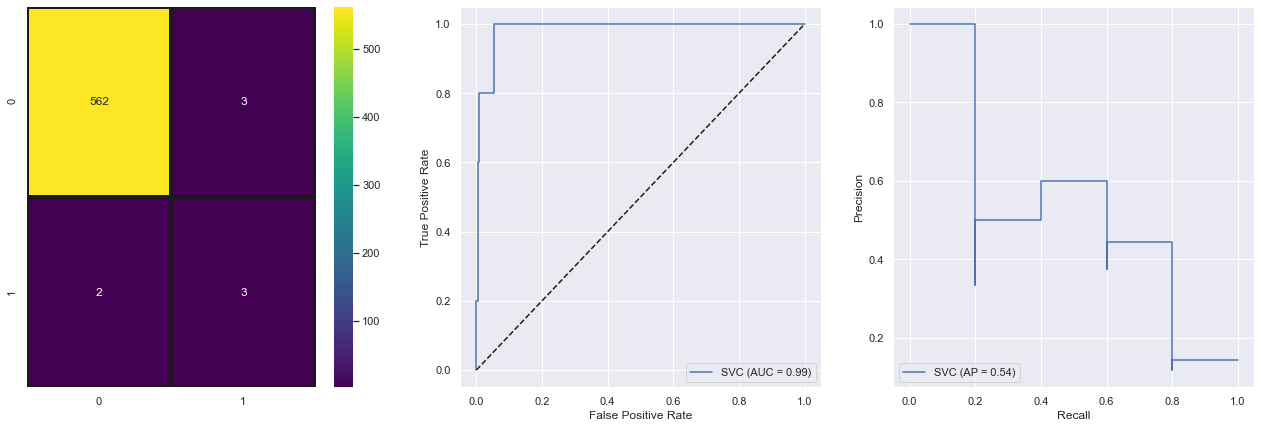

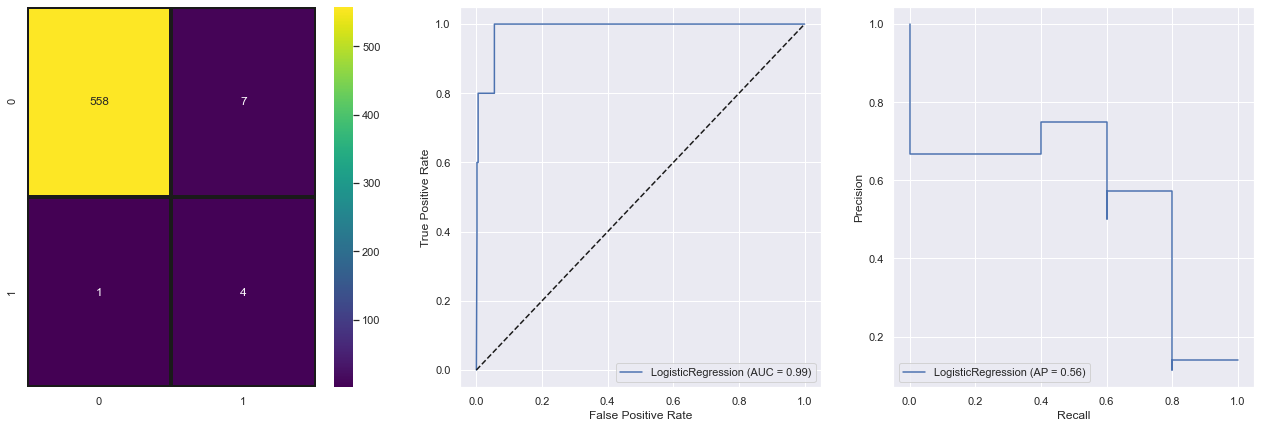

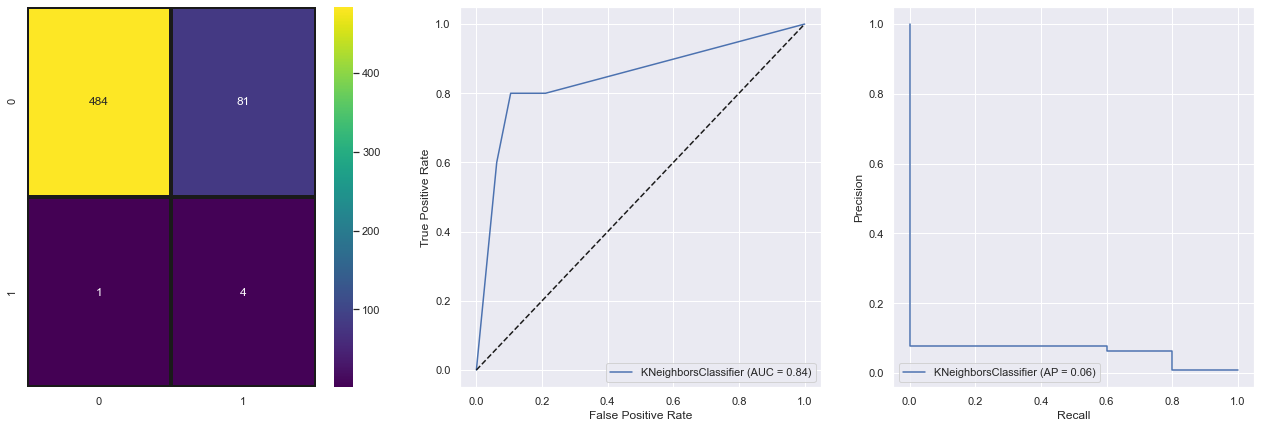

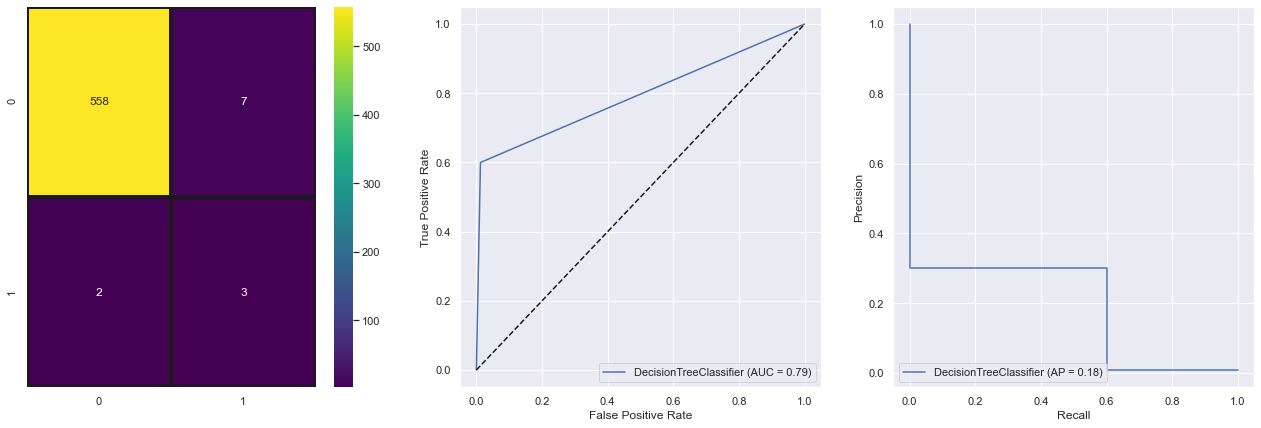

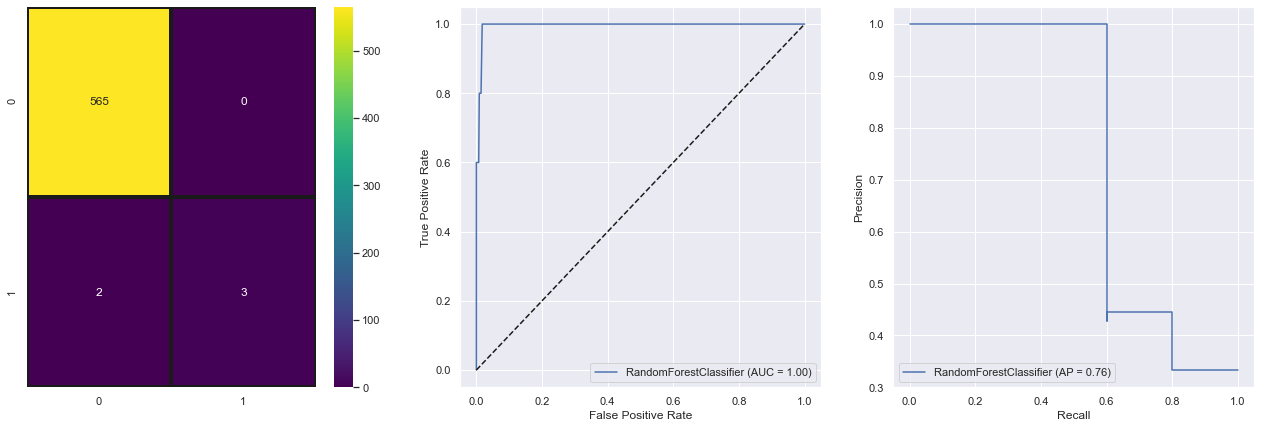

In [55]:
%%time
X_train, X_test, y_train, y_test = reset_data(train_data, test_data)
X_train = data_prep_4.fit_transform(X_train)
X_test = data_prep_4.fit_transform(X_test)

sm = SMOTE(random_state=42, n_jobs=-1)
X_train, y_train = sm.fit_resample(X_train, y_train)
print("After OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train==0)))

for m in models:
    test_model(m, X_train, X_test, y_train, y_test)

Primjenom SMOTE-a nije se baš puno promijenilo, čak su zapravo neki algoritmi lošije performali. Logističkoj regresiji se recimo smanjila preciznost, ali ima isti recall. To znači više false positiva. Dok nam je to svakako draže of false negativa ne bismo htjeli baš ni previše false positiva.

Ne možemo tvrditi sigurno pa bi sljedeći korak bio za 2-3 najbolja kandidata pomoću GridSearchCV testirati parametre kako bi ih fine-tunali. Probati ćemo to sa i bez oversamplanja manjine.

In [30]:
# %%
# parameters = {
#     'n_estimators': [10,20,30,40,50],
#     'max_depth': list(range(1, 11)),
#     'criterion':['gini','entropy'],
#     'max_features': list(range(1,20)),
#     'oob_score':[False,True],
# }

# %%
# grid = GridSearchCV(forest, parameters, cv=5, verbose=3, n_jobs=-1)

In [31]:
#Cross validation
means = []
variances = []
for m in models:
    accuracies = cross_val_score(estimator = m, X = X_train, y = y_train, cv = 5, n_jobs = -1)
    mean = accuracies.mean()
    variance = accuracies.std()
    means.append(mean)
    variances.append(variance)
#     print(type(m).__name__)
#     print(f"Accuracy mean: {mean}")
#     print(f"Accuracy variance: {variance} \n")

In [51]:
for mod,m,v in zip(models,means,variances):
    mod_ = type(mod).__name__
    error = np.sqrt(v)/np.sqrt(5)
    print(f"{mod_}: {m} +- {error}")

SVC: 0.9974870834817627 +- 0.016644648652638695
LogisticRegression: 0.9978889924736805 +- 0.010829012061105382
KNeighborsClassifier: 0.9339567621920564 +- 0.040221034011649635
DecisionTreeClassifier: 0.9940695938212937 +- 0.01944293127401388
RandomForestClassifier: 0.9996984924623116 +- 0.008966716793244523


In [33]:
# parameters = {
#     'n_estimators': [20,30,40,50],
#     'max_depth': list(range(4, 17)),
#     'criterion':['gini','entropy'],
#     'max_features': list(range(9,17)),
#     'oob_score':[False,True],
# }

# grid = GridSearchCV(forest, parameters, cv=5, verbose=3, n_jobs=-1, return_train_score=True)

In [34]:
# grid.fit(X_train, y_train)

In [35]:
# grid.best_estimator_


Najbolji estimator round 1 sa pravim test data: RandomForestClassifier(max_depth=4, max_features=9, n_estimators=20, n_jobs=1, oob_score=True)

In [36]:

# confusion_matrix(y_test, y_pred)

In [37]:
# grid.best_estimator_.score(X_test, y_test)

In [38]:
# y_pred = grid.predict(X_test)

In [39]:
# confusion_matrix(y_test, y_pred)

Zapiklo sam najbolji model

In [40]:
# from joblib import dump, load
# joblib.dump(grid, "forest_grid_2.pkl")
# loaded = joblib.load("forest_grid_2.pkl")

In [41]:
# X_train, X_test, y_train, y_test = reset_data(train_data, test_data)
# X_train = data_prep_2.fit_transform(X_train)
# X_test = data_prep_2.fit_transform(X_test)

# # sm = SMOTE(random_state=42, n_jobs=-1)
# # X_train, y_train = sm.fit_resample(X_train, y_train)
# # print("After OverSampling, counts of label '1': {}".format(sum(y_train==1)))
# # print("After OverSampling, counts of label '0': {}".format(sum(y_train==0)))

In [42]:
# draw_exo(X_train, 37)
# draw_noexo(X_train,12)

PCA grozno utječe na podatke i nije bilo baš korisno. Barem na podacima na kojima je napravljena Fourierova transformacija.

In [43]:
# pca = PCA()
# X_pca = pca.fit_transform(X_train)

In [44]:
# total = sum(pca.explained_variance_)
# k=0
# current_variance=0
# while current_variance/total < 0.99:
#     current_variance += pca.explained_variance_[k]
#     k=k+1
# print(f"k = {k}")

In [45]:
# pca = PCA(n_components=k)
# x_train = pca.fit_transform(X_train)
# x_test = pca.fit_transform(X_test)

In [46]:
# draw_exo(x_train, 4)
# draw_noexo(x_train,4)

In [47]:
# #Cross validation
# means = []
# variances = []
# for m in models:
#     accuracies = cross_val_score(estimator = m, X = x_train, y = y_train, cv = 5, n_jobs = -1)
#     mean = accuracies.mean()
#     variance = accuracies.std()
#     means.append(mean)
#     variances.append(variance)
#     print(type(m).__name__)
#     print(f"Accuracy mean: {mean}")
#     print(f"Accuracy variance: {variance} \n")

In [48]:
# %%time
# # X_train, X_test, y_train, y_test = reset_data(train_data, test_data)
# # X_train = data_prep_2.fit_transform(X_train)
# # X_test = data_prep_2.fit_transform(X_test)

# sm = SMOTE(random_state=42, n_jobs=-1)
# x_train, y_train = sm.fit_resample(x_train, y_train)
# print("After OverSampling, counts of label '1': {}".format(sum(y_train==1)))
# print("After OverSampling, counts of label '0': {}".format(sum(y_train==0)))

# for m in models:
#      test_model(m, x_train, x_test, y_train, y_test)

## Fine-tuning logističke regresije

In [46]:
X_train, X_test, y_train, y_test = reset_data(train_data, test_data)
X_train = data_prep_2.fit_transform(X_train)
X_test = data_prep_2.fit_transform(X_test)

# sm = SMOTE(random_state=42, n_jobs=-1)
# X_train, y_train = sm.fit_resample(X_train, y_train)
# print("After OverSampling, counts of label '1': {}".format(sum(y_train==1)))
# print("After OverSampling, counts of label '0': {}".format(sum(y_train==0)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.6s finished



LogisticRegression

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       565
           1       0.36      0.80      0.50         5

    accuracy                           0.99       570
   macro avg       0.68      0.89      0.75       570
weighted avg       0.99      0.99      0.99       570

F1: 0.5000000000000001
Wall time: 5.13 s


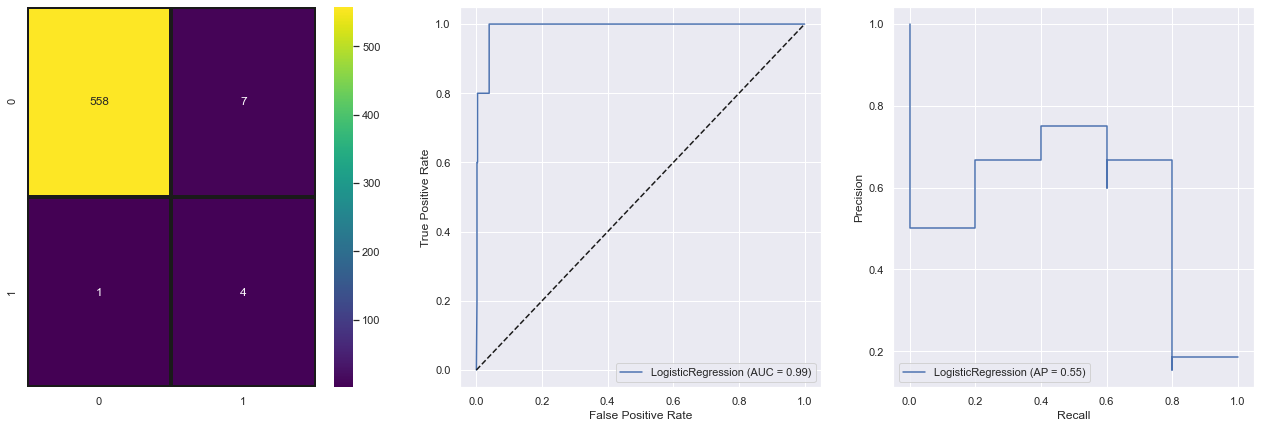

In [47]:
%%time
logreg = LogisticRegression(max_iter=500, n_jobs=-1, random_state=42, verbose=1, class_weight="balanced")

test_model(logreg, X_train, X_test, y_train, y_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.9min finished



LogisticRegressionCV

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       565
           1       0.33      0.80      0.47         5

    accuracy                           0.98       570
   macro avg       0.67      0.89      0.73       570
weighted avg       0.99      0.98      0.99       570

F1: 0.47058823529411764


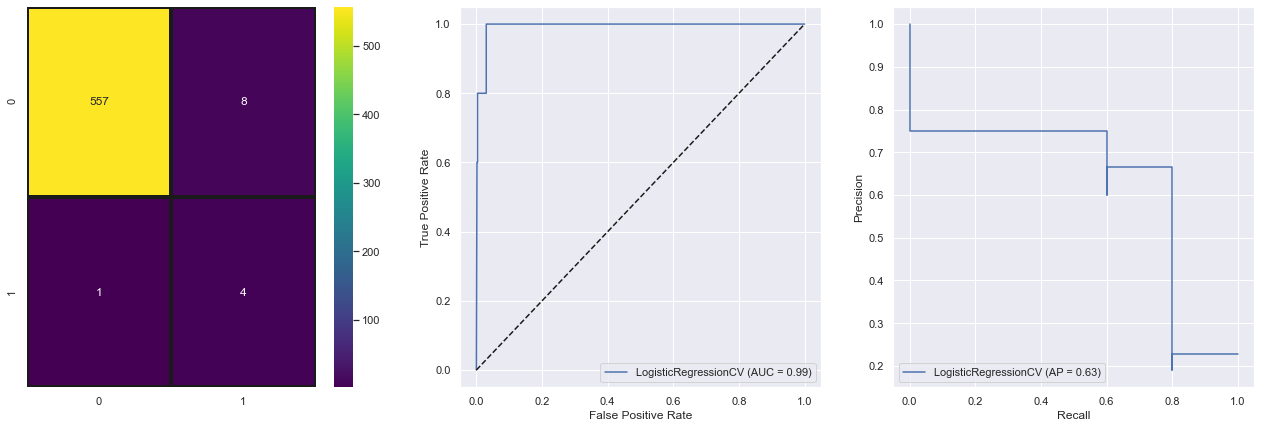

In [21]:
from sklearn.linear_model import LogisticRegressionCV

logregcv = LogisticRegressionCV(max_iter=500, n_jobs=-1, random_state=42, verbose=1, cv=5)
test_model(logregcv, X_train, X_test, y_train, y_test)

In [ ]:
parameters = {
    "max_iter": [500],
    "C": list(range(1,5)),
    "class_weight": [None],
    "solver": ["lbfgs", "sag", "saga"],
    #"n_jobs": [-1],
}
 #   "random_state": [42],
# logreg = LogisticRegression(max_iter=500, n_jobs=-1, random_state=42, verbose=1, class_weight="balanced")

logreg = LogisticRegression()

grid = GridSearchCV(logreg, parameters, cv=5, verbose=3, n_jobs=-1, return_train_score=True)

In [93]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 23.3min finished


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1, 2, 3, 4], 'class_weight': [None],
                         'max_iter': [500],
                         'solver': ['lbfgs', 'sag', 'saga']},
             return_train_score=True, verbose=3)

In [94]:
grid.score(X_test,y_test)
grid.best_estimator_.score(X_test, y_test)
y_pred = grid.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[561,   4],
       [  1,   4]], dtype=int64)

In [97]:
# import joblib
# joblib.dump(grid, "logreg.pkl")
# loaded = joblib.load("logreg.pkl")

['logreg.pkl']

In [99]:
loaded = joblib.load("logreg.pkl")

In [113]:
results = pd.DataFrame(grid.cv_results_)
results.sort_values(by="rank_test_score")["mean_test_score"]

0     0.995609
6     0.995210
9     0.995210
3     0.995010
1     0.994411
4     0.994411
7     0.994411
10    0.994411
2     0.994012
5     0.994012
8     0.994012
11    0.994012
Name: mean_test_score, dtype: float64

In [61]:
#results = pd.DataFrame(grid.cv_results_)
#results

In [77]:
# results.sort_values(by='rank_test_recall', inplace=True)
# results

In [78]:
# results.sort_values(by='rank_test_accuracy', inplace=True)
# results[""]

In [297]:
X_train, X_test, y_train, y_test = reset_data(train_data, test_data)
X_train = data_prep_2.fit_transform(X_train)
X_test = data_prep_2.fit_transform(X_test)

sm = SMOTE(random_state=42, n_jobs=-1)
X_train, y_train = sm.fit_resample(X_train, y_train)
print("After OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train==0)))

After OverSampling, counts of label '1': 4974
After OverSampling, counts of label '0': 4974


In [102]:
%%time
logreg = LogisticRegression(fit_intercept=True, max_iter=1000)
logreg.fit(X_train, y_train)

Wall time: 9.44 s


LogisticRegression(max_iter=1000)

In [103]:
y_pred = logreg.predict(X_test)
confusion_matrix(y_test,y_pred)
#list(y_pred)[6:].index(1)

array([[558,   7],
       [  1,   4]], dtype=int64)

# Crtanje decision boundary za dva stupca

In [ ]:
X_train, X_test, y_train, y_test = reset_data(train_data, test_data)
X_train = data_prep_2.fit_transform(X_train)
X_test = data_prep_2.fit_transform(X_test)

sm = SMOTE(random_state=42, n_jobs=-1)
X_train, y_train = sm.fit_resample(X_train, y_train)
print("After OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train==0)))

(-2.33266859168358, 9.36733140831643)

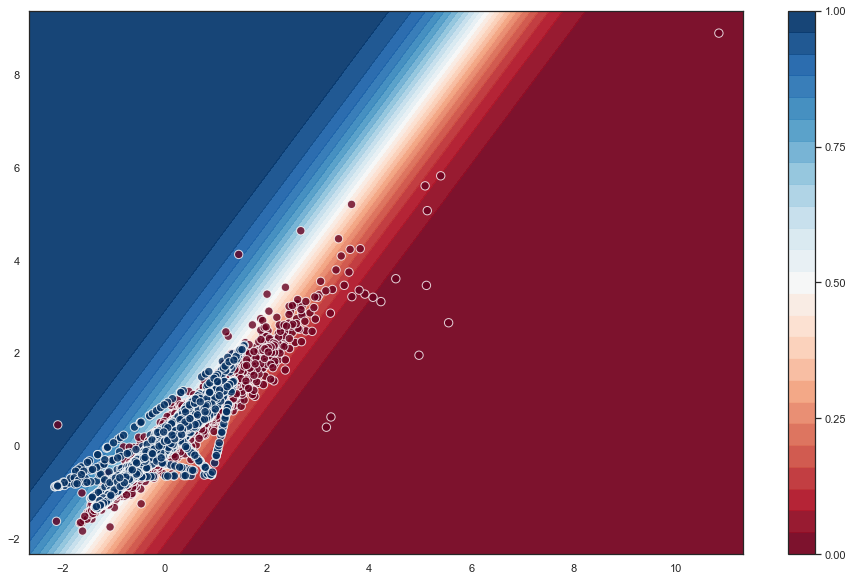

In [357]:
#koje feature crtamo
mini_x, maxi_x = 40, 41
X = X_train[:,mini_x:(maxi_x+1)]
y = y_train

#fitaj model
logreg.fit(X,y)


#odredi granice
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])
probs = logreg.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)
Z = Z.reshape(xx.shape)

#crtanje
plt.figure(1, figsize=(16, 10))
#plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.5, vmin=0, vmax=1)
contour = plt.contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1, alpha=0.95)
ax_c = plt.colorbar()
ax_c.set_ticks([0, .25, .5, .75, 1])
# Ovo crta baš granicu
#plt.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors="white", s=70, cmap="RdBu", alpha=0.8)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#plt.xticks(())
#plt.yticks(())
#plt.xlabel('Sepal length')
#plt.ylabel('Sepal width')

(-2.4867652394436184, 3.473234760556387)

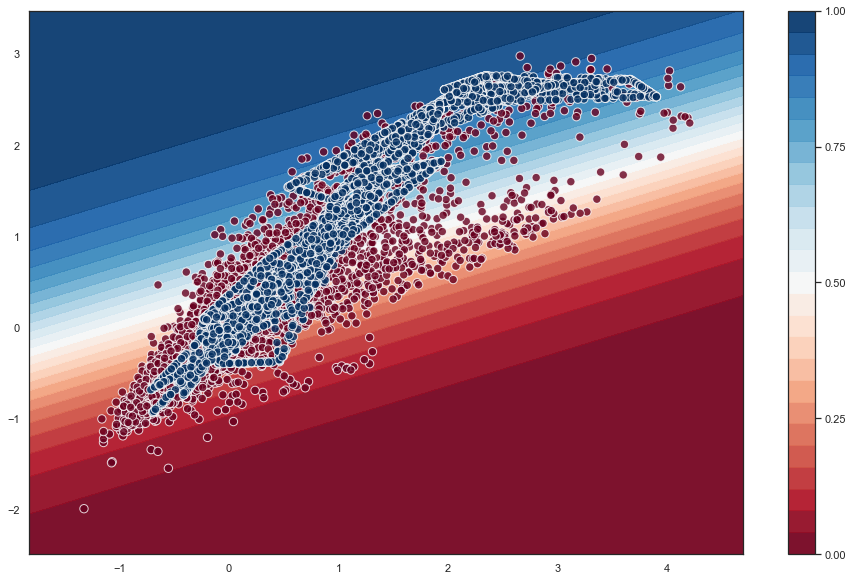

In [352]:
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(16, 10))
#plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.5, vmin=0, vmax=1)
contour = plt.contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1, alpha=0.95)
ax_c = plt.colorbar()
ax_c.set_ticks([0, .25, .5, .75, 1])
# Ovo crta baš granicu
#plt.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors="white", s=70, cmap="RdBu", alpha=0.8)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#plt.xticks(())
#plt.yticks(())
#plt.xlabel('Sepal length')
#plt.ylabel('Sepal width')

In [136]:
importance = logreg.coef_[0]
imp = importance[:100]
imp2 = importance[-100:]

<BarContainer object of 100 artists>

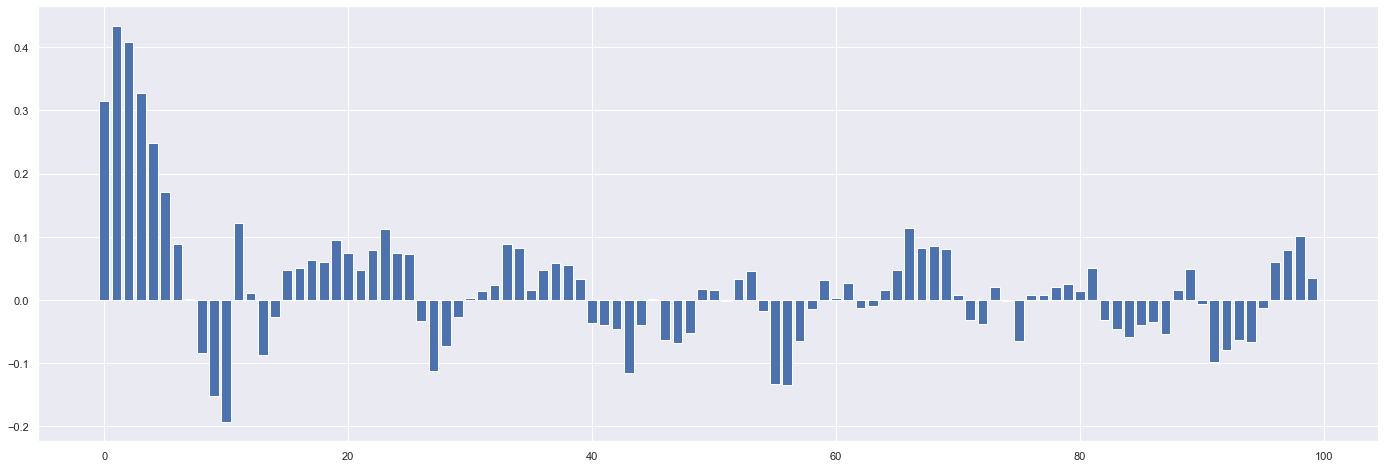

In [137]:
plt.figure(figsize=(24,8))
plt.bar([x for x in range(len(imp))], imp)

<BarContainer object of 100 artists>

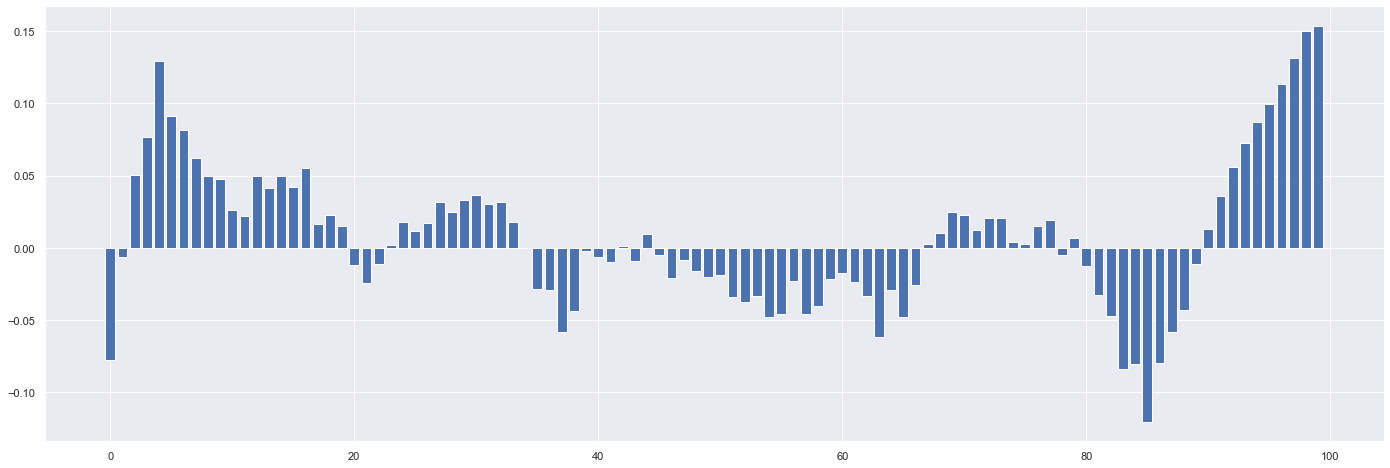

In [138]:
plt.figure(figsize=(24,8))
plt.bar([x for x in range(len(imp2))], imp2,)

<BarContainer object of 1599 artists>

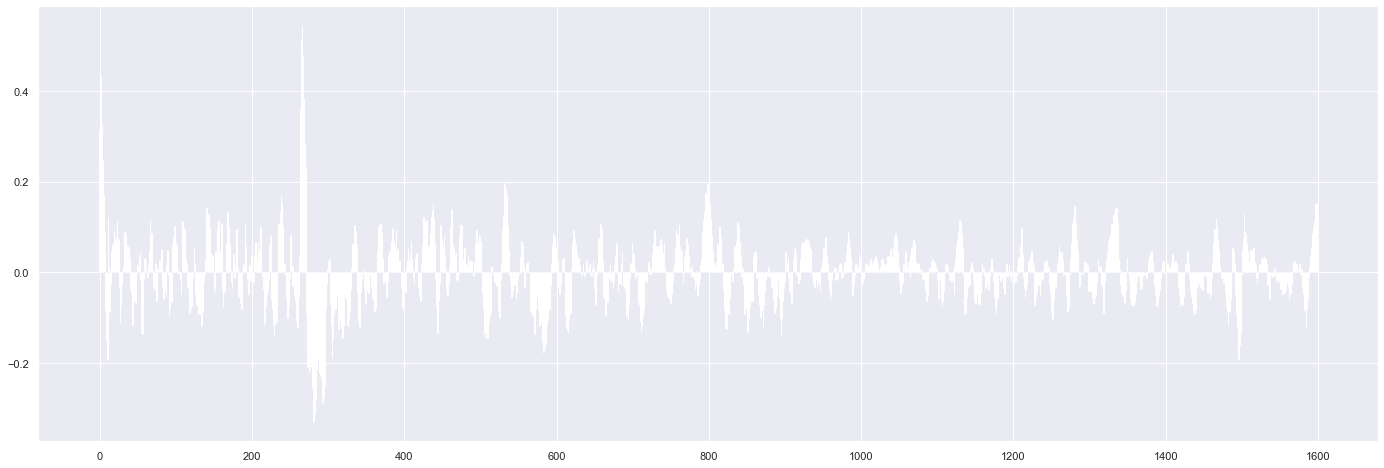

In [139]:
plt.figure(figsize=(24,8))
plt.bar([x for x in range(len(importance))], importance, color = "blue")

In [140]:
%%time
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
confusion_matrix(y_test,y_pred)

Wall time: 14.3 s


array([[548,  17],
       [  0,   5]], dtype=int64)

In [141]:
# %%time
# forest = RandomForestClassifier(random_state=42)
# forest.fit(X_train, y_train)
# y_pred = forest.predict(X_test)
# confusion_matrix(y_test,y_pred)

In [142]:
importance = tree.feature_importances_
imp = importance[:100]
imp2 = importance[-100:]

<BarContainer object of 100 artists>

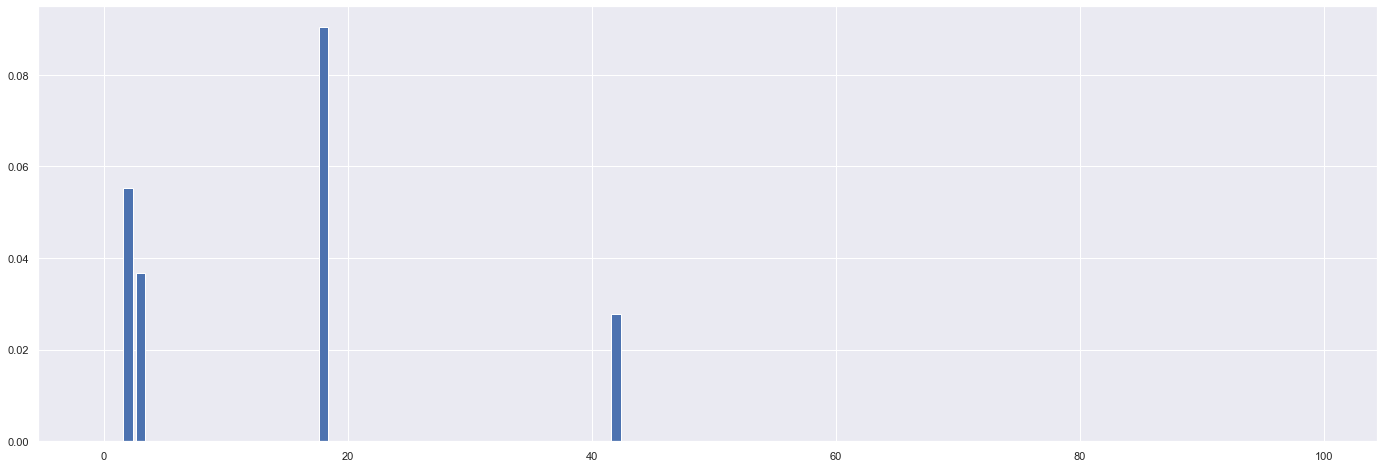

In [143]:
plt.figure(figsize=(24,8))
plt.bar([x for x in range(len(imp))], imp)

<BarContainer object of 100 artists>

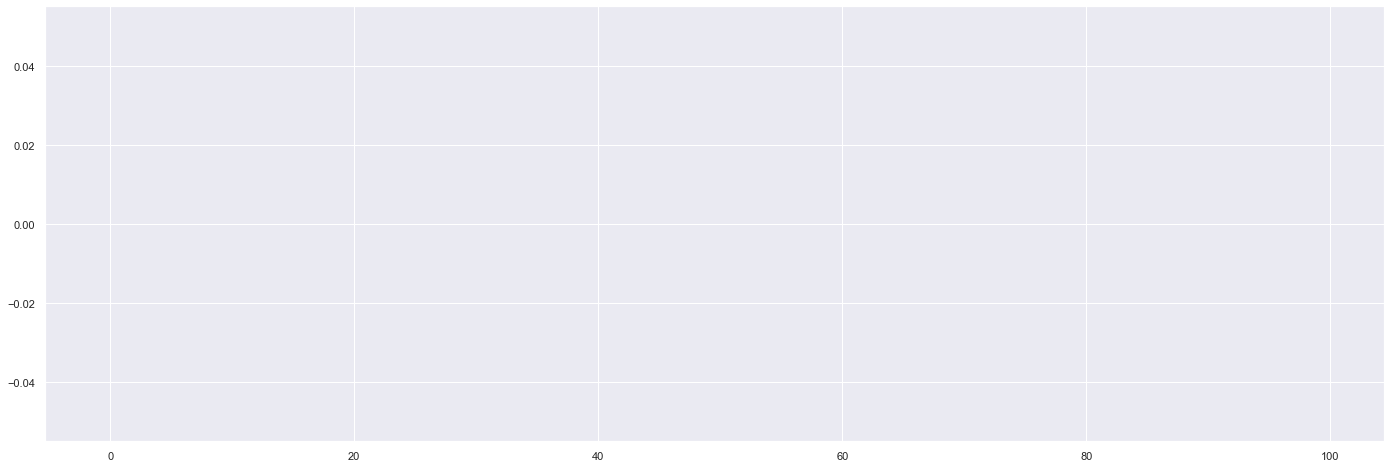

In [144]:
plt.figure(figsize=(24,8))
plt.bar([x for x in range(len(imp2))], imp2,)

<BarContainer object of 1599 artists>

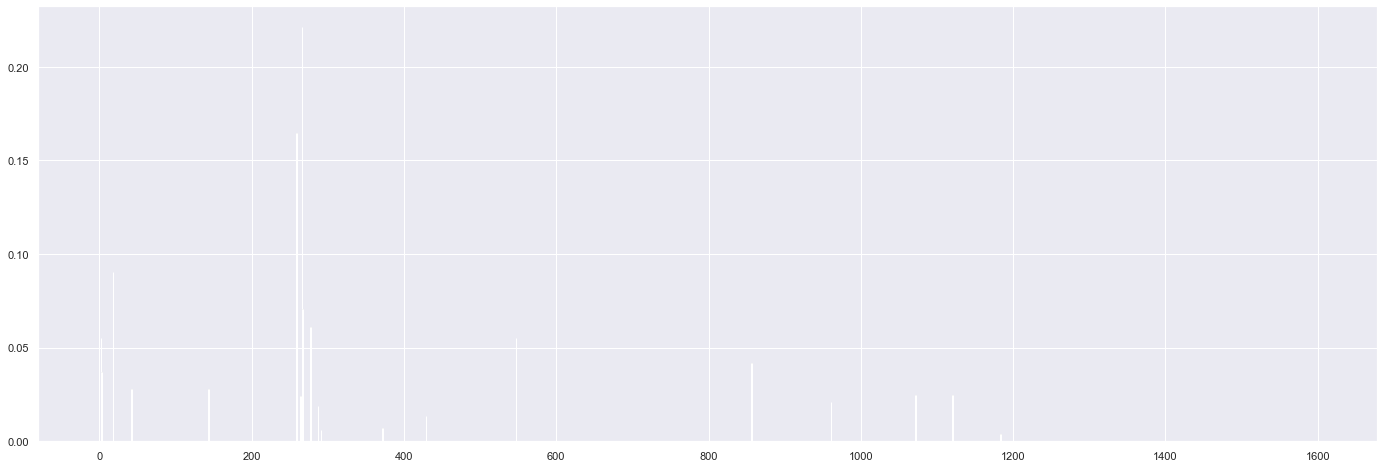

In [145]:
plt.figure(figsize=(24,8))
plt.bar([x for x in range(len(importance))], importance, color = "black")

# Cross-validation

## Cross val models

In [ ]:
# models = [svc, logreg, knn, tree, forest]

In [30]:
%%time
from sklearn.model_selection import cross_validate

X_train, X_test, y_train, y_test = reset_data(train_data, test_data)
X_train = data_prep_2.fit_transform(X_train)
X_test = data_prep_2.fit_transform(X_test)

results = []

for m in models:
    r = cross_validate(logreg, X_train, y_train, n_jobs=-1, verbose=0, scoring=["accuracy","precision","recall"], cv=5)
    results.append(r)

Wall time: 1min 21s


### Prije micanja outliera
{'fit_time': 9.19855170249939, 'score_time': 0.012476634979248048, 'test_accuracy': 0.9946921972827358, 'test_precision': 0.6694444444444444, 'test_recall': 0.5607142857142857}

{'fit_time': 8.472763967514037, 'score_time': 0.011496496200561524, 'test_accuracy': 0.9946921972827358, 'test_precision': 0.6694444444444444, 'test_recall': 0.5607142857142857}

{'fit_time': 8.638683128356934, 'score_time': 0.01341261863708496, 'test_accuracy': 0.9946921972827358, 'test_precision': 0.6694444444444444, 'test_recall': 0.5607142857142857}

{'fit_time': 9.16487421989441, 'score_time': 0.01119089126586914, 'test_accuracy': 0.9946921972827358, 'test_precision': 0.6694444444444444, 'test_recall': 0.5607142857142857}

{'fit_time': 8.673823976516724, 'score_time': 0.010185146331787109, 'test_accuracy': 0.9946921972827358, 'test_precision': 0.6694444444444444, 'test_recall': 0.5607142857142857}

In [31]:
avgres = {}
for i in range(len(results)):
    for k,v in results[i].items():
        # v is the list of grades for student k
        avgres[k] = sum(v)/ float(len(v))
    print(avgres)
# models = [svc, logreg, knn, tree, forest]

{'fit_time': 10.270580625534057, 'score_time': 0.010404586791992188, 'test_accuracy': 0.9954091816367265, 'test_precision': 0.8166666666666667, 'test_recall': 0.5214285714285714}
{'fit_time': 10.270800733566285, 'score_time': 0.01089491844177246, 'test_accuracy': 0.9954091816367265, 'test_precision': 0.8166666666666667, 'test_recall': 0.5214285714285714}
{'fit_time': 9.756343936920166, 'score_time': 0.011585330963134766, 'test_accuracy': 0.9954091816367265, 'test_precision': 0.8166666666666667, 'test_recall': 0.5214285714285714}
{'fit_time': 9.304882383346557, 'score_time': 0.010598850250244141, 'test_accuracy': 0.9954091816367265, 'test_precision': 0.8166666666666667, 'test_recall': 0.5214285714285714}
{'fit_time': 8.6792142868042, 'score_time': 0.010579299926757813, 'test_accuracy': 0.9954091816367265, 'test_precision': 0.8166666666666667, 'test_recall': 0.5214285714285714}


In [33]:
%%time
from sklearn.model_selection import cross_validate

X_train, X_test, y_train, y_test = reset_data(train_data, test_data)
X_train = data_prep_2.fit_transform(X_train)
X_test = data_prep_2.fit_transform(X_test)

sm = SMOTE(random_state=42, n_jobs=-1)
X_train, y_train = sm.fit_resample(X_train, y_train)
print("After OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train==0)))

results = []

for m in models:
    r = cross_validate(logreg, X_train, y_train, n_jobs=-1, verbose=0, scoring=["accuracy","precision","recall"], cv=5)
    results.append(r)

After OverSampling, counts of label '1': 4974
After OverSampling, counts of label '0': 4974
Wall time: 3min


In [34]:
avgres = {}
for i in range(len(results)):
    for k,v in results[i].items():
        # v is the list of grades for student k
        avgres[k] = sum(v)/ float(len(v))
    print(avgres)
# models = [svc, logreg, knn, tree, forest]

{'fit_time': 22.462439870834352, 'score_time': 0.018616580963134767, 'test_accuracy': 0.9975874344068256, 'test_precision': 0.9951995919911752, 'test_recall': 1.0}
{'fit_time': 23.77969365119934, 'score_time': 0.01907072067260742, 'test_accuracy': 0.9975874344068256, 'test_precision': 0.9951995919911752, 'test_recall': 1.0}
{'fit_time': 21.96000657081604, 'score_time': 0.01635775566101074, 'test_accuracy': 0.9975874344068256, 'test_precision': 0.9951995919911752, 'test_recall': 1.0}
{'fit_time': 23.25173125267029, 'score_time': 0.018180656433105468, 'test_accuracy': 0.9975874344068256, 'test_precision': 0.9951995919911752, 'test_recall': 1.0}
{'fit_time': 23.365616846084595, 'score_time': 0.018002843856811522, 'test_accuracy': 0.9975874344068256, 'test_precision': 0.9951995919911752, 'test_recall': 1.0}


### Prije micanja outliera
{'fit_time': 25.974575567245484, 'score_time': 0.01855125427246094, 'test_accuracy': 0.9973267326732673, 'test_precision': 0.9946944754737013, 'test_recall': 1.0}

{'fit_time': 33.89341926574707, 'score_time': 0.019360923767089845, 'test_accuracy': 0.9973267326732673, 'test_precision': 0.9946944754737013, 'test_recall': 1.0}

{'fit_time': 33.658046913146975, 'score_time': 0.017598438262939452, 'test_accuracy': 0.9973267326732673, 'test_precision': 0.9946944754737013, 'test_recall': 1.0}

{'fit_time': 30.536409044265746, 'score_time': 0.015898752212524413, 'test_accuracy': 0.9973267326732673, 'test_precision': 0.9946944754737013, 'test_recall': 1.0}

{'fit_time': 29.206036615371705, 'score_time': 0.017399072647094727, 'test_accuracy': 0.9973267326732673, 'test_precision': 0.9946944754737013, 'test_recall': 1.0}

In [35]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)

PCA()

In [42]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
#plt.figure(figsize=(10,8))
#plt.plot(range(len(cumsum)),cumsum)

In [43]:
pca = PCA(n_components=400)
X_train_red = pca.fit_transform(X_train)
X_test_red = pca.fit_transform(X_test)

In [48]:
#draw_noexo(X_train_red,37)

## Cross val logreg

In [12]:
%%time
X_train, X_test, y_train, y_test = reset_data(train_data, test_data)
X_train = data_prep_2.fit_transform(X_train)
X_test = data_prep_2.fit_transform(X_test)

cross_val_score(logreg,X_train, y_train, n_jobs=-1, verbose=1)

Wall time: 23.4 s


array([0.99600798, 0.99500998, 0.99600798, 0.99500998, 0.99500998])

In [13]:
%%time
from sklearn.model_selection import cross_validate

X_train, X_test, y_train, y_test = reset_data(train_data, test_data)
X_train = data_prep_2.fit_transform(X_train)
X_test = data_prep_2.fit_transform(X_test)

cross_validate(logreg, X_train, y_train, n_jobs=-1, verbose=1, scoring=["accuracy","precision","recall"])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.8s finished


{'fit_time': array([8.38757157, 5.93213725, 7.36131549, 8.26091146, 3.90057373]),
 'score_time': array([0.00797796, 0.01197052, 0.01197004, 0.01096964, 0.00398469]),
 'test_accuracy': array([0.99600798, 0.99500998, 0.99600798, 0.99500998, 0.99500998]),
 'test_recall': array([0.75      , 0.57142857, 0.42857143, 0.57142857, 0.28571429])}

## Cross val tree

In [101]:
%%time

X_train, X_test, y_train, y_test = reset_data(train_data, test_data)
X_train = data_prep_2.fit_transform(X_train)
X_test = data_prep_2.fit_transform(X_test)

cross_validate(tree, X_train, y_train, n_jobs=-1, verbose=1, scoring=["accuracy","precision","recall"])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.0s finished


Wall time: 29.7 s


{'fit_time': array([13.36426735, 13.00024033, 14.06838489, 16.06903434,  9.92247009]),
 'score_time': array([0.01097035, 0.01296568, 0.01097059, 0.01000381, 0.00701022]),
 'test_accuracy': array([0.98802395, 0.98502994, 0.99001996, 0.99001996, 0.99101796]),
 'test_precision': array([0.33333333, 0.1       , 0.33333333, 0.2       , 0.33333333]),
 'test_recall': array([0.5       , 0.14285714, 0.42857143, 0.14285714, 0.28571429])}

In [103]:
X_train, X_test, y_train, y_test = reset_data(train_data, test_data)
X_train = data_prep_2.fit_transform(X_train)
X_test = data_prep_2.fit_transform(X_test)

sm = SMOTE(random_state=42, n_jobs=-1)
X_train, y_train = sm.fit_resample(X_train, y_train)
print("After OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train==0)))

cross_validate(tree, X_train, y_train, n_jobs=-1, verbose=1, scoring=["accuracy","precision","recall"])

After OverSampling, counts of label '1': 4974
After OverSampling, counts of label '0': 4974


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   33.8s finished


{'fit_time': array([16.78721714, 18.51958537, 18.24232697, 18.34505224, 13.94175792]),
 'score_time': array([0.01994729, 0.02293849, 0.01994753, 0.01994729, 0.01192904]),
 'test_accuracy': array([0.99346734, 0.99296482, 0.99296482, 0.99547511, 0.99396682]),
 'test_precision': array([0.99198397, 0.99197593, 0.98709037, 0.993     , 0.99198397]),
 'test_recall': array([0.99497487, 0.99396985, 0.99899497, 0.99798995, 0.99597586])}

# Prije SMOTE su loši recall, a nakon SMOTE su super na cross validationu

# Grid search logreg

In [82]:
X_train, X_test, y_train, y_test = reset_data(train_data, test_data)
X_train = data_prep_2.fit_transform(X_train)
X_test = data_prep_2.fit_transform(X_test)

sm = SMOTE(random_state=42, n_jobs=-1)
X_train, y_train = sm.fit_resample(X_train, y_train)
print("After OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train==0)))

After OverSampling, counts of label '1': 4974
After OverSampling, counts of label '0': 4974


In [83]:
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [115]:
parameters = {
    "max_iter": [500],
    "C": np.arange(0,1.1,0.1),
    "class_weight": [None],
    "solver": ["lbfgs"],
    "n_jobs": [-1],
    "fit_intercept": [True,False],
    "penalty": ["l2"]
}
 #   "random_state": [42],
# logreg = LogisticRegression(max_iter=500, n_jobs=-1, random_state=42, verbose=1, class_weight="balanced")

logreg = LogisticRegression()

grid = GridSearchCV(logreg, parameters, cv=5, verbose=3, n_jobs=-1, return_train_score=True)

In [116]:
grid.fit(X_train_val, y_train_val)

Fitting 5 folds for each of 22 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:  6.3min finished


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'class_weight': [None], 'fit_intercept': [True, False],
                         'max_iter': [500], 'n_jobs': [-1], 'penalty': ['l2'],
                         'solver': ['lbfgs']},
             return_train_score=True, verbose=3)

In [117]:
import joblib
#joblib.dump(grid, "logreg-17520211552.pkl")
#loaded = joblib.load("logreg.pkl")

['logreg-17520211552.pkl']

In [118]:
pd.DataFrame(grid.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0        0.210237      0.017360         0.000000        0.000000       0   
1        0.213428      0.010630         0.000000        0.000000       0   
2        9.109349      0.663519         0.012096        0.001904     0.1   
3       10.320655      0.280230         0.011971        0.001093     0.1   
4       10.455447      1.184714         0.011567        0.006058     0.2   
5       13.351182      0.274015         0.007313        0.006268     0.2   
6       11.409161      1.096338         0.013629        0.001782     0.3   
7       14.640347      0.447254         0.014559        0.001445     0.3   
8       12.885549      0.840282         0.014627        0.000814     0.4   
9       16.407884      0.361508         0.012499        0.006249     0.4   
10      12.150313      1.028275         0.012831        0.003157     0.5   
11      18.930957      0.711419         0.011566        0.006057     0.5   
12      13.470642      0.726725         0.011767        0.006051     0.6   
13      17.928082      0.454115         0.012897        0.001789     0.6   
14      14.602155      1.827916         0.011502        0.005821     0.7   
15      17.989543      0.087811         0.012365        0.006188     0.7   
16      14.571982      1.487204         0.008443        0.007099     0.8   
17      18.750733      0.311532         0.009373        0.007653     0.8   
18      15.891606      1.857308         0.010577        0.003758     0.9   
19      18.429734      0.293208         0.014360        0.001578     0.9   
20      15.384511      1.992550         0.011833        0.005963       1   
21      16.501682      1.908755         0.010238        0.006242       1   

   param_class_weight param_fit_intercept param_max_iter param_n_jobs  \
0                None                True            500           -1   
1                None               False            500           -1   
2                None                True            500           -1   
3                None               False            500           -1   
4                None                True            500           -1   
5                None               False            500           -1   
6                None                True            500           -1   
7                None               False            500           -1   
8                None                True            500           -1   
9                None               False            500           -1   
10               None                True            500           -1   
11               None               False            500           -1   
12               None                True            500           -1   
13               None               False            500           -1   
14               None                True            500           -1   
15               None               False            500           -1   
16               None                True            500           -1   
17               None               False            500           -1   
18               None                True            500           -1   
19               None               False            500           -1   
20               None                True            500           -1   
21               None               False            500           -1   

   param_penalty  ... mean_test_score std_test_score  rank_test_score  \
0             l2  ...             NaN            NaN               22   
1             l2  ...             NaN            NaN               21   
2             l2  ...        0.996783       0.001431               10   
3             l2  ...        0.957780       0.001702               20   
4             l2  ...        0.996917       0.001505                9   
5             l2  ...        0.962471       0.002204               19   
6             l2  ...        0.997185       0.001367            

In [119]:
y_pred = grid.best_estimator_.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[557,   8],
       [  1,   4]], dtype=int64)

In [100]:
grid.best_estimator_

LogisticRegression(C=6, max_iter=500, n_jobs=-1)


LogisticRegression

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       565
           1       0.50      0.80      0.62         5

    accuracy                           0.99       570
   macro avg       0.75      0.90      0.81       570
weighted avg       0.99      0.99      0.99       570

F1: 0.6153846153846154

DecisionTreeClassifier

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       565
           1       0.14      0.80      0.24         5

    accuracy                           0.96       570
   macro avg       0.57      0.88      0.61       570
weighted avg       0.99      0.96      0.97       570

F1: 0.24242424242424243
Wall time: 20.9 s


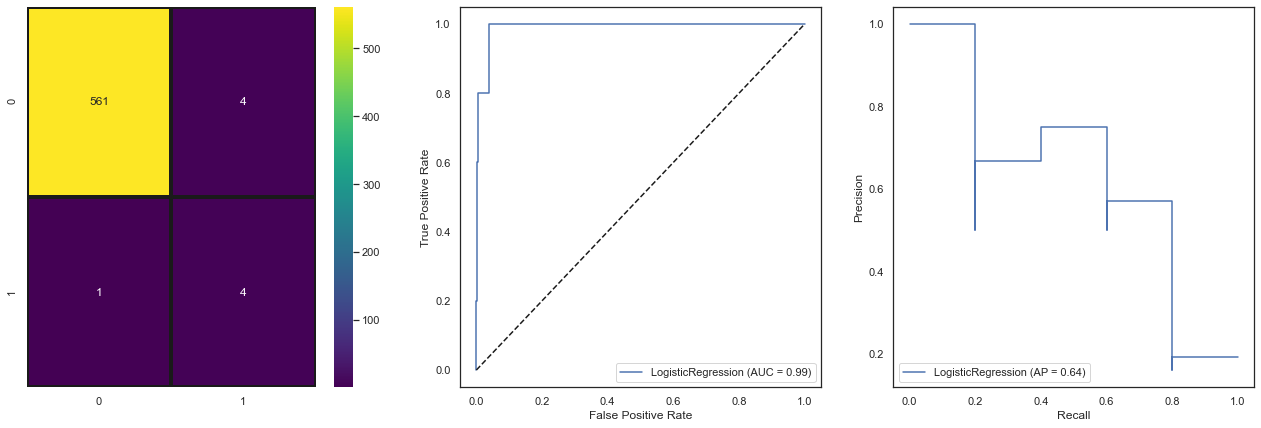

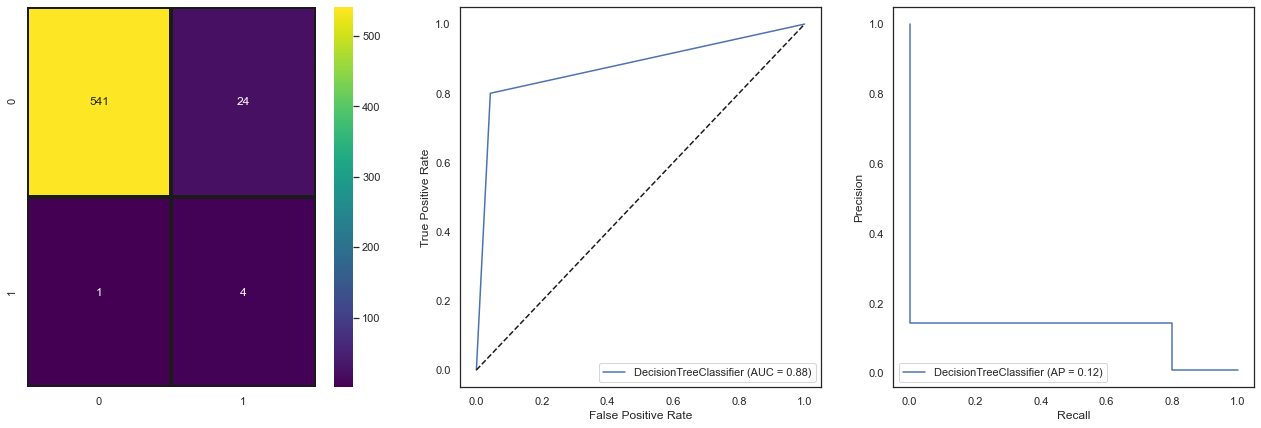

In [17]:
%%time
X_train, X_test, y_train, y_test = reset_data(train_data, test_data)
X_train = data_prep_2.fit_transform(X_train)
X_test = data_prep_2.fit_transform(X_test)

logreg = LogisticRegression(max_iter=1000, n_jobs=-1)
tree = DecisionTreeClassifier()

test_model(logreg, X_train, X_test, y_train, y_test)
test_model(tree, X_train, X_test, y_train, y_test)

After OverSampling, counts of label '1': 4974
After OverSampling, counts of label '0': 4974

LogisticRegression

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       565
           1       0.25      1.00      0.40         5

    accuracy                           0.97       570
   macro avg       0.62      0.99      0.69       570
weighted avg       0.99      0.97      0.98       570

F1: 0.4

DecisionTreeClassifier

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       565
           1       0.60      0.60      0.60         5

    accuracy                           0.99       570
   macro avg       0.80      0.80      0.80       570
weighted avg       0.99      0.99      0.99       570

F1: 0.6
Wall time: 20.5 s


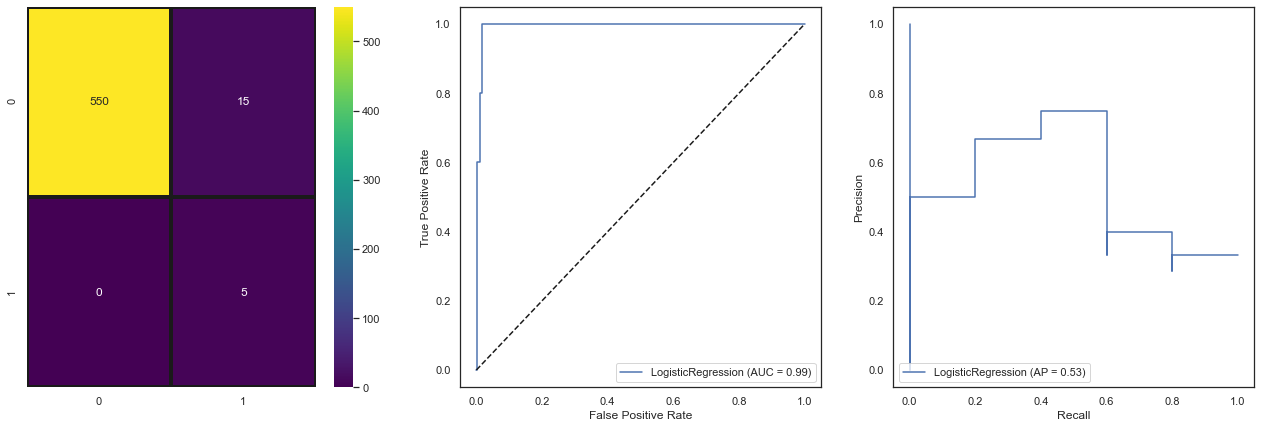

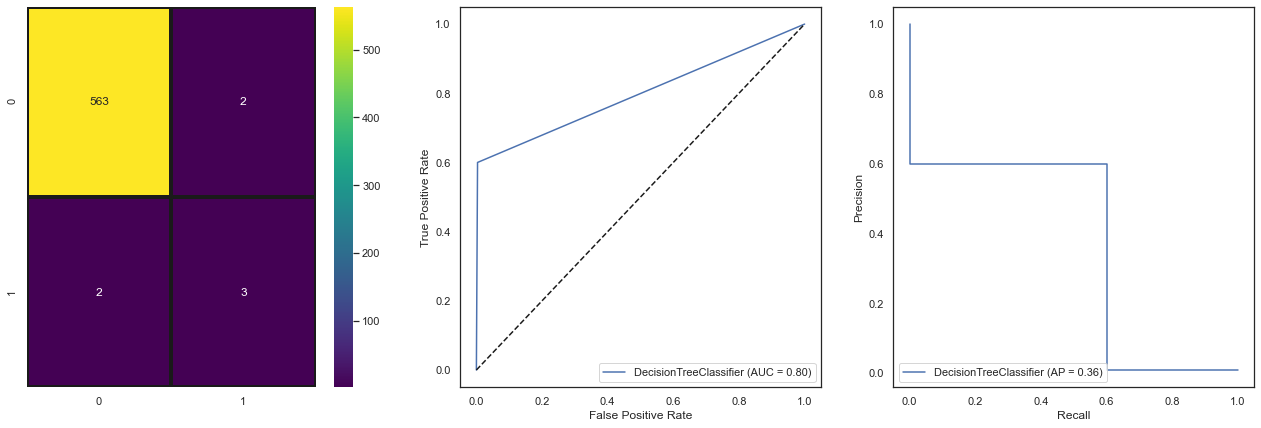

In [43]:
%%time
X_train, X_test, y_train, y_test = reset_data(train_data, test_data)
X_train = data_prep_5.fit_transform(X_train)
X_test = data_prep_5.fit_transform(X_test)

sm = SMOTE(random_state=42, n_jobs=-1)
X_train, y_train = sm.fit_resample(X_train, y_train)
print("After OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train==0)))

logreg = LogisticRegression(max_iter=1000, n_jobs=-1)
tree = DecisionTreeClassifier()

test_model(logreg, X_train, X_test, y_train, y_test)
test_model(tree, X_train, X_test, y_train, y_test)